In [43]:
using CmdStan, Distributions, Dates, Plots, Plots.PlotMeasures

In [44]:
ENV["JULIA_CMDSTAN_HOME"]="/Users/marlinfiggins/cmdstan/"

"/Users/marlinfiggins/cmdstan/"

In [45]:
include("../../Bayesian_Time_Series/src/BayesTS.jl")
using .BayesTS

In [227]:
# Expanding BayesTS to multivariate TS
function BayesTS.get_prior_string(TS::TimeSeriesNode, priors, s_idx::Int, e_idx::Int)
    n_dists = length(priors)
    if priors[1] == "LAS"
        prior_str = "zgam ~ uniform(0., 1.);
\nb[$(s_idx)] ~ normal(0.,1.); 
\nfor (t in $(s_idx):$(e_idx-1)){
  b[t+1] ~ double_exponential(b[t], gam);
}
\n// ADD_MORE_PRIORS \n" 
        return prior_str
    end

    # If one distribution is provided, provide to all arguments
    if n_dists == 1 && n_dists != params_shape(TS)
        prior_tmp = "to_vector(b[$s_idx : $e_idx]) ~ PRIOR_TEXT; \n // ADD_MORE_PRIORS \n" 
        prior_tmp = "to_vector(b[$(s_idx):$(e_idx), :]) ~ PRIOR_TEXT; \n // ADD_MORE_PRIORS \n" 
        #prior_tmp = "to_vector(b[$(s_idx):$(e_idx)]) ~ PRIOR_TEXT; \n // ADD_MORE_PRIORS \n" 
        #prior_str = replace(prior_tmp, "PRIOR_TEXT" => BayesTS.stan_string(priors[1]))
    end

    if n_dists == params_shape(TS) || (s_idx == e_idx)
        
        #prior_tmp = "b[IDX_TEST, :] ~ PRIOR_TEXT; \n"
        prior_tmp = "b[IDX_TEST] ~ PRIOR_TEXT; \n"
  
        prior_str = ""
        for i in 1:n_dists
            tmp = replace(prior_tmp, "IDX_TEST" => "$(s_idx+i-1)")
            prior_str *= replace(tmp, "PRIOR_TEXT" => BayesTS.stan_string(priors[i]))
        end

        prior_str *= "// ADD_MORE_PRIORS"
    end
    
    return prior_str
end

function add_misc_string!(model_file, TS::TimeSeriesNode, priors, s_idx::Int, e_idx::Int)
    if priors[1] == "LAS"
        str_1 = "real<lower=0, upper=1> zgam; // Squared Global Variance
\n// ADD_MORE_PARMS \n"

str_2 = "real gam = 0.5 * tan(zgam * pi() / 2.); // Random Walk Variance
\n // ADD_MORE_TRANS_PARMS"
        
        model_file = replace(model_file, "// ADD_MORE_PARMS" => str_1)
        model_file = replace(model_file, "// ADD_MORE_TRANS_PARMS" => str_2)
    end
    return model_file
end

function add_other_parms(model_file, model, priors=nothing)
    if isnothing(priors)
        return model_file
    end
            
    # Count indices in β
    current_index = 1
    new_index = current_index - 1

    for i in 1:n_components(model)
        new_index += params_shape(model[i])
        model_file = add_misc_string!(model_file, model[i], priors[i], current_index, new_index)
        current_index += params_shape(model[i])
    end
    return model_file
end



# Model definition function for Rt models
function define_stan_model(TS::TimeSeriesNode; priors = nothing, num_samples = 1000, obs_dist = nothing)
    # How do we decide which file to use?

    # Load Base File and add Priors
    # Use joinpath and @__DIR__
    model_file = read("../src/stan_models/Rt_Structured_lineage.stan", String)
    model_file = add_priors(model_file, TS, priors)
    model_file = add_other_parms(model_file, TS, priors)
    
    stan_model = StanSample.SampleModel("Rt_Structured_lineage", model_file;
    method = StanSample.Sample(
    save_warmup=false,
    thin=2,
    num_samples = num_samples,
    num_warmup = 3000,
    ),
        tmpdir = pwd() * "/test_RT_lineage"
    )

    return stan_model
end

define_stan_model (generic function with 3 methods)

In [228]:
## Loading Data

In [229]:
using DataFrames, CSV, Query
include("../../university-transmission-dynamics/src/InferenceHelpers.jl")
include("../../university-transmission-dynamics/src/PlotFunctions.jl")

include("../../rt_from_lineage_frequencies/src/DataHelpers.jl")
include("../../rt_from_lineage_frequencies/src/InferenceHelpers.jl")
include("../../rt_from_lineage_frequencies/src/PlotStates.jl")
df = DataFrame(CSV.File("../../rt_from_lineage_frequencies/data/raw/cases-lineage-sequence-counts-2021-09-23.tsv"))

,state,date,cases,sequences_total,sequences_other,sequences_B.1.1.7
,String,Date,Int64,Int64,Int64,Int64
1,Alabama,2021-01-28,2340,0,0,0
2,Alabama,2021-01-29,1967,5,5,0
3,Alabama,2021-01-30,1253,0,0,0
4,Alabama,2021-01-31,1228,1,1,0
5,Alabama,2021-02-01,2476,15,13,1
6,Alabama,2021-02-02,1997,17,17,0
7,Alabama,2021-02-03,1742,1,0,1
8,Alabama,2021-02-04,1649,2,2,0
9,Alabama,2021-02-05,1582,39,37,1


In [230]:
function get_data_for_inference(seed_L, forecast_L, 
        C, sequence_counts, N_seqs, 
        g, onset, model::TimeSeriesNode; is_sim=false)

    true_L, N_deme = size(sequence_counts)

    # How much data to pass to model
    L, obs_period = get_data_obs_period(true_L, seed_L, forecast_L, is_sim)
    
    t = collect(1:L)
    X = get_design(model, t)
    
    stan_data = Dict(
        "seed_L" => seed_L,
        "forecast_L" => forecast_L,
        "L" => L,
        "N_lineage" => N_deme,
        "cases" => Int.(C)[obs_period],
        "num_sequenced" => sequence_counts[obs_period, :],
        "N_sequences" => Int.(N_seqs)[obs_period],
        "g" => g,
        "onset" => onset,
        "l" => length(g),
        "K" => size(X, 2),
        "features" => X
    )
    return stan_data
end

 function process_state_data_for_stan(state, df, g, onset, seed_L, forecast_L, model::TimeSeriesNode)
    state_df = load_state_data(state, df)
    seq_cols, seq_counts, seq_total = sequence_counts_to_matrix(state_df)
    cases = cases_to_vector(state_df)
    
    stan_data = get_data_for_inference(seed_L, forecast_L,
                                     cases, seq_counts,  seq_total, 
                                     g, onset, model)
    
    return state_df[:, :date], seq_cols, stan_data
end

function define_stan_model(state, filename, model::TimeSeriesNode, priors)
    # Construct Model 
    model_string = read(filename, String);
    model_string = add_priors(model_string, model, priors)
    model_string = add_other_parms(model_string, model, priors)
    
    method = Sample(save_warmup = false, num_samples = 1000, num_warmup = 2000)
    #method = Variational(grad_samples=1, elbo_samples=100, tol_rel_obj = 1e-4, output_samples=1000, iter=200000)
    #method = Optimize(iter = 2000)
    
     stan_model = Stanmodel(
        method,
        nchains = 4,
        name = "rt-lineages-" * state,   
        tmpdir = cd(pwd, "..") * "/data/sims/rt-lineage-test/" * state,
        model = model_string); 
    
   # stan_model = Stanmodel(Optimize(iter = 2000),
   #  name = "rt-lineages-" * state,   
   #  tmpdir = cd(pwd, "..") * "/data/sims/rt-lineage-test-" * state,
   #  model = model_string); 
 end

function process_all_states(filename, df, g, onset, seed_L, forecast_L, model::TimeSeriesNode, priors = nothing)
    state_names = unique(df[: , :state])
    states_dict = Dict()
    
    for state in state_names
        dates_vec, seq_labels, state_data = process_state_data_for_stan(state, df, g, onset, seed_L, forecast_L, model)
        state = replace(state, ' ' => '_')
        state_model = define_stan_model(state, filename, model, priors)
        
       states_dict[state] = Dict(
        "date" => dates_vec,
        "seq_labels" => clean_labels(seq_labels, state_data),
        "stan_data" => state_data,
        "stan_model" => state_model
        )
    end
    
    return states_dict    
end

process_all_states (generic function with 3 methods)

## Modeling

In [231]:
# Load Lifetimes
include("../../university-transmission-dynamics/src/lifetimes.jl")

g = generation_time(20, 5.0, 0.3)
onset = onset_time(20, 4.5, 0.6, 0.8)

20-element Vector{Float64}:
 0.15422107788295136
 0.5979776824957601
 0.8
 0.7462640695453
 0.6021072988929602
 0.45527929483634866
 0.33419359901772533
 0.24227494594996882
 0.175034123856333
 0.12664182163034848
 0.09201514722705773
 0.06723952335640869
 0.049455997273909
 0.0366271997771212
 0.02731671924777422
 0.020515169042784314
 0.015512579078432101
 0.011807873345391351
 0.009045677113215203
 0.006972500059309538

In [232]:
SoI = "California"
num_SoI = size(filter(row -> row.state == SoI, df), 1)
chosen_seed_L = 14

14

In [233]:
# Choose Basis Model

#model = LinearTrend(40, 140) + FlatTrend()
#prior_model = [ [Laplace(0.0, 0.3)], [Laplace(0.0, 0.5)]]
#prior_model = [ [Normal(0.0, 0.3)], [Normal(0.0, 0.5)]]

# Need some way of getting this length easier 
#model = SplineTrend(20, num_SoI + chosen_seed_L, 4) + ConstantTrend(1, num_SoI + chosen_seed_L)
#prior_model = [ ["LAS"], [Laplace(0.0, 0.5)]]
#Urgent: Function to use just trend no FlatTrend
model = SplineTrend(15,  num_SoI, 4)
prior_model = [ ["LAS"]]

1-element Vector{Vector{String}}:
 ["LAS"]

In [238]:
states_dict = process_all_states("../src/stan_models/Rt_Structured_lineage_ind.stan", df, 
    g, onset, chosen_seed_L, 0, model, prior_model)

#states_dict = process_all_states("../src/stan_models/Rt_Structured_lineage.stan", df, 
#    g, onset, 14, 0, model, prior_model)


File /Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test/Alabama/rt-lineages-Alabama.stan will be updated.


File /Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test/Alaska/rt-lineages-Alaska.stan will be updated.


File /Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test/Arizona/rt-lineages-Arizona.stan will be updated.


File /Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test/Arkansas/rt-lineages-Arkansas.stan will be updated.


File /Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test/California/rt-lineages-California.stan will be updated.


File /Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test/Colorado/rt-lineages-Colorado.stan will be updated.


File /Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test/Connecticut/rt-lineages-Connecticut.stan will be updated.


File /Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test/Florida/rt-

Dict{Any, Any} with 46 entries:
  "Colorado"       => Dict{String, Any}("seq_labels"=>SubString{String}["B.1.1.…
  "Texas"          => Dict{String, Any}("seq_labels"=>SubString{String}["B.1.1.…
  "Alabama"        => Dict{String, Any}("seq_labels"=>SubString{String}["B.1.1.…
  "Vermont"        => Dict{String, Any}("seq_labels"=>SubString{String}["B.1.1.…
  "Missouri"       => Dict{String, Any}("seq_labels"=>SubString{String}["B.1.1.…
  "Wyoming"        => Dict{String, Any}("seq_labels"=>SubString{String}["B.1.1.…
  "California"     => Dict{String, Any}("seq_labels"=>SubString{String}["B.1.1.…
  "Maine"          => Dict{String, Any}("seq_labels"=>SubString{String}["B.1.1.…
  "New_Mexico"     => Dict{String, Any}("seq_labels"=>SubString{String}["B.1.1.…
  "Tennessee"      => Dict{String, Any}("seq_labels"=>SubString{String}["B.1.1.…
  "Nevada"         => Dict{String, Any}("seq_labels"=>SubString{String}["B.1.1.…
  "Kentucky"       => Dict{String, Any}("seq_labels"=>SubString{String}["B.1.

In [239]:
states_dict[SoI]["stan_data"]

Dict{String, Any} with 12 entries:
  "cases"         => [18709, 16502, 15278, 13530, 10644, 8410, 16045, 13258, 12…
  "L"             => 217
  "g"             => [2.99452e-5, 0.0104006, 0.106806, 0.245483, 0.261926, 0.18…
  "N_sequences"   => [1281, 528, 685, 777, 470, 903, 1037, 926, 784, 417  …  12…
  "l"             => 20
  "features"      => [1.0 0.0 … 0.0 0.0; 0.817886 0.176017 … 0.0 0.0; … ; 0.0 0…
  "num_sequenced" => [14 0 … 0 547; 11 0 … 0 212; … ; 4 0 … 0 2; 0 0 … 0 1]
  "onset"         => [0.154221, 0.597978, 0.8, 0.746264, 0.602107, 0.455279, 0.…
  "K"             => 17
  "seed_L"        => 14
  "forecast_L"    => 0
  "N_lineage"     => 8

In [240]:
states_dict[SoI]["stan_model"]

  name =                    "rt-lineages-California"
  nchains =                 4
  num_samples =             1000
  num_warmup =                1000
  thin =                    1
  monitors =                String[]
  model_file =              "rt-lineages-California.stan"
  data_file =               ""
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  pdir =                   "/Users/marlinfiggins/Documents/Structural_Rt/notebooks"
  tmpdir =                 "/Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test/California"
  output_format =           :array
  method =                  Sample()
    num_samples =             1000
    num_warmup =              2000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  CmdStan

In [241]:
CmdStan.set_cmdstan_home!(ENV["JULIA_CMDSTAN_HOME"])
run_stan_model!(SoI, states_dict)

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[2] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test/California/rt-lineages-California.stan', line 216, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[2] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test/California/rt-lineages-California.stan', line 216, column 2 to column 81)
If this warning occurs sporadically, such as for highly

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[3] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test/California/rt-lineages-California.stan', line 216, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[3] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test/California/rt-lineages-California.stan', line 216, column 2 to column 81)
If this warning occurs sporadically, such as for highly


An error occurred while running the previously compiled Stan program.

Please check the contents of file rt-lineages-California_run.log and the'command' field in the Stanmodel, e.g. stanmodel.command.



LoadError: Return code = -5

In [114]:
load_state_samples!(SoI, states_dict)

LoadError: MethodError: no method matching iterate(::Nothing)
[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m) at range.jl:664
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Int64[39m) at range.jl:664
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{var"#s79", var"#s78"} where {var"#s79", var"#s78"<:Dict}, Base.ValueIterator{var"#s77"} where var"#s77"<:Dict} at dict.jl:693
[0m  ...

In [90]:
idx = findall(x -> contains(x, "I0."), states_dict[SoI]["stan_cnames"])
states_dict[SoI]["stan_cnames"][idx]

16-element Vector{String}:
 "zI0.1"
 "zI0.2"
 "zI0.3"
 "zI0.4"
 "zI0.5"
 "zI0.6"
 "zI0.7"
 "zI0.8"
 "I0.1"
 "I0.2"
 "I0.3"
 "I0.4"
 "I0.5"
 "I0.6"
 "I0.7"
 "I0.8"

In [91]:
smp = states_dict[SoI]["stan_results"][:, idx[5] , :]
Plots.plot(smp)

LoadError: KeyError: key (Colon(), 44, Colon()) not found

In [92]:
is_divergent = reduce(vcat, get_posterior(states_dict, SoI, "divergent__", false))

LoadError: MethodError: no method matching size(::Dict{Any, Any})
[0mClosest candidates are:
[0m  size([91m::Union{LinearAlgebra.QR, LinearAlgebra.QRCompactWY, LinearAlgebra.QRPivoted}[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/qr.jl:524
[0m  size([91m::Union{LinearAlgebra.QR, LinearAlgebra.QRCompactWY, LinearAlgebra.QRPivoted}[39m, [91m::Integer[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/qr.jl:523
[0m  size([91m::Union{LinearAlgebra.Cholesky, LinearAlgebra.CholeskyPivoted}[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/cholesky.jl:442
[0m  ...

In [93]:
yes_no(x) = x == 1 ? :red : :green

yes_no (generic function with 1 method)

In [94]:
xi = reduce(vcat, get_posterior(states_dict, SoI, "xi", false))
CairoMakie.scatter(xi, color = yes_no.(is_divergent))

LoadError: MethodError: no method matching size(::Dict{Any, Any})
[0mClosest candidates are:
[0m  size([91m::Union{LinearAlgebra.QR, LinearAlgebra.QRCompactWY, LinearAlgebra.QRPivoted}[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/qr.jl:524
[0m  size([91m::Union{LinearAlgebra.QR, LinearAlgebra.QRCompactWY, LinearAlgebra.QRPivoted}[39m, [91m::Integer[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/qr.jl:523
[0m  size([91m::Union{LinearAlgebra.Cholesky, LinearAlgebra.CholeskyPivoted}[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/cholesky.jl:442
[0m  ...

In [95]:
zalpha = reduce(vcat, get_posterior(states_dict, SoI, "zalpha", false))
CairoMakie.scatter(zalpha, color = yes_no.(is_divergent))

LoadError: MethodError: no method matching size(::Dict{Any, Any})
[0mClosest candidates are:
[0m  size([91m::Union{LinearAlgebra.QR, LinearAlgebra.QRCompactWY, LinearAlgebra.QRPivoted}[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/qr.jl:524
[0m  size([91m::Union{LinearAlgebra.QR, LinearAlgebra.QRCompactWY, LinearAlgebra.QRPivoted}[39m, [91m::Integer[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/qr.jl:523
[0m  size([91m::Union{LinearAlgebra.Cholesky, LinearAlgebra.CholeskyPivoted}[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/cholesky.jl:442
[0m  ...

In [96]:
CairoMakie.scatter(xi, zalpha, color = yes_no.(is_divergent))

LoadError: UndefVarError: is_divergent not defined

## Cairo Figs


In [97]:
# Wrap these in functions so it's easy to run one state at a time

In [200]:
using CairoMakie

In [201]:
lineage_colors = [ "#5081b9" "pink" "#ffdf64" "orange" "#ccf5ac" "#ff6666" "#8a897c" ]
lineage_colors = ["#2e5eaa", "#5adbff", "#b4c5e4","#f5bb00","#56e39f", "#9e4244", "#f03a47", "#808080"]
alphas = [0.65, 0.45, 0.35]
#lQuants = [0.25 0.1]
#uQuants = [0.75 0.9]
lQuants = [0.25 0.1 0.025]
uQuants = [0.75 0.9 0.975]
ps = (uQuants - lQuants)

1×3 Matrix{Float64}:
 0.5  0.8  0.95

In [202]:
dates = states_dict[SoI]["date"]
dates_num = collect(1:length(dates))
seed_L = states_dict[SoI]["stan_data"]["seed_L"]
dates_num_ws = collect((-seed_L+1):(length(dates)))
dates_ws = dates[1] + Day.(dates_num_ws)
seq_labels = vcat(states_dict[SoI]["seq_labels"]...)

8-element Vector{SubString{String}}:
 "B.1.1.7"
 "B.1.351"
 "B.1.427"
 "B.1.526"
 "B.1.617.2"
 "B.1.621"
 "P.1"
 "other"

In [203]:
lineage_map = Dict()
for (i, lineage) in enumerate(sort(seq_labels))
    lineage_map[lineage] = i
end

lineage_map
# lineage to who map

Dict{Any, Any} with 8 entries:
  "B.1.526"   => 4
  "B.1.621"   => 6
  "P.1"       => 7
  "other"     => 8
  "B.1.1.7"   => 1
  "B.1.351"   => 2
  "B.1.617.2" => 5
  "B.1.427"   => 3

In [204]:
# seq_names to WHO
lineage_to_WHO = Dict()
lineage_to_WHO["B.1.1.7"] = "Alpha"
lineage_to_WHO["B.1.351"] = "Beta"
lineage_to_WHO["P.1"] = "Gamma"
lineage_to_WHO["B.1.617.2"] = "Delta"
lineage_to_WHO["B.1.525"] = "Eta"
lineage_to_WHO["B.1.526"] = "Iota "
lineage_to_WHO["B.1.617.1"] = "Kappa"
lineage_to_WHO["C.37"] = "Lambda"
lineage_to_WHO["other"] = "other"
lineage_to_WHO["B.1.427"] = "Epsilon"
lineage_to_WHO["B.1.621"] = "Mu"

WHO_seq_names = [lineage_to_WHO[lineage] for lineage in seq_labels]

8-element Vector{String}:
 "Alpha"
 "Beta"
 "Epsilon"
 "Iota "
 "Delta"
 "Mu"
 "Gamma"
 "other"

In [205]:
function get_posterior(states_dict, SoI, var, multi)
    if multi == true
        sample_posterior(states_dict[SoI]["stan_results"], 
                    states_dict[SoI]["stan_cnames"],
                    states_dict[SoI]["stan_data"]["N_lineage"], var)
    else
        sample_posterior(states_dict[SoI]["stan_results"], 
                    states_dict[SoI]["stan_cnames"], var)
    end
end

get_posterior (generic function with 1 method)

In [206]:
R = get_posterior(states_dict, SoI, "R.", true)
lQ, uQ, med = sim_stats_multi(R, lQuants, uQuants)
lQ, uQ, med = parse_by_deme(lQ, uQ, med)

([[2.6182475 2.4870189999999996 2.47142625; 2.1331124999999997 2.04922 2.038687; … ; 0.78742625 0.7446725000000001 0.701421375; 0.76909075 0.7192645000000001 0.6683423], [0.0054860575 0.002575009 0.00106237325; 0.0044522550000000004 0.0020895489999999996 0.000860289675; … ; 0.0017309699999999999 0.0008235262 0.00032958142499999994; 0.0016991925000000001 0.0008113605 0.0003281102], [2.0979375 1.996908 1.9835095; 1.7081275 1.645107 1.63624975; … ; 0.63002625 0.5962834 0.56220305; 0.615676 0.5756996 0.5347936], [2.52367 2.413968 2.3979484999999996; 2.0565075 1.989168 1.97725775; … ; 0.76126775 0.7199879 0.67899985; 0.74300075 0.6958049000000001 0.645640175], [0.0056447675 0.002720486 0.0011456749999999999; 0.004579059999999999 0.002208409 0.00092680215; … ; 0.001787375 0.000853723 0.0003669322; 0.00175983 0.0008474957 0.000365256225], [0.0053293225 0.002633823 0.00123003675; 0.0043169175 0.0021317629999999996 0.0009952358249999999; … ; 0.0016949 0.0008290055 0.0003751506; 0.0016810475 0.0

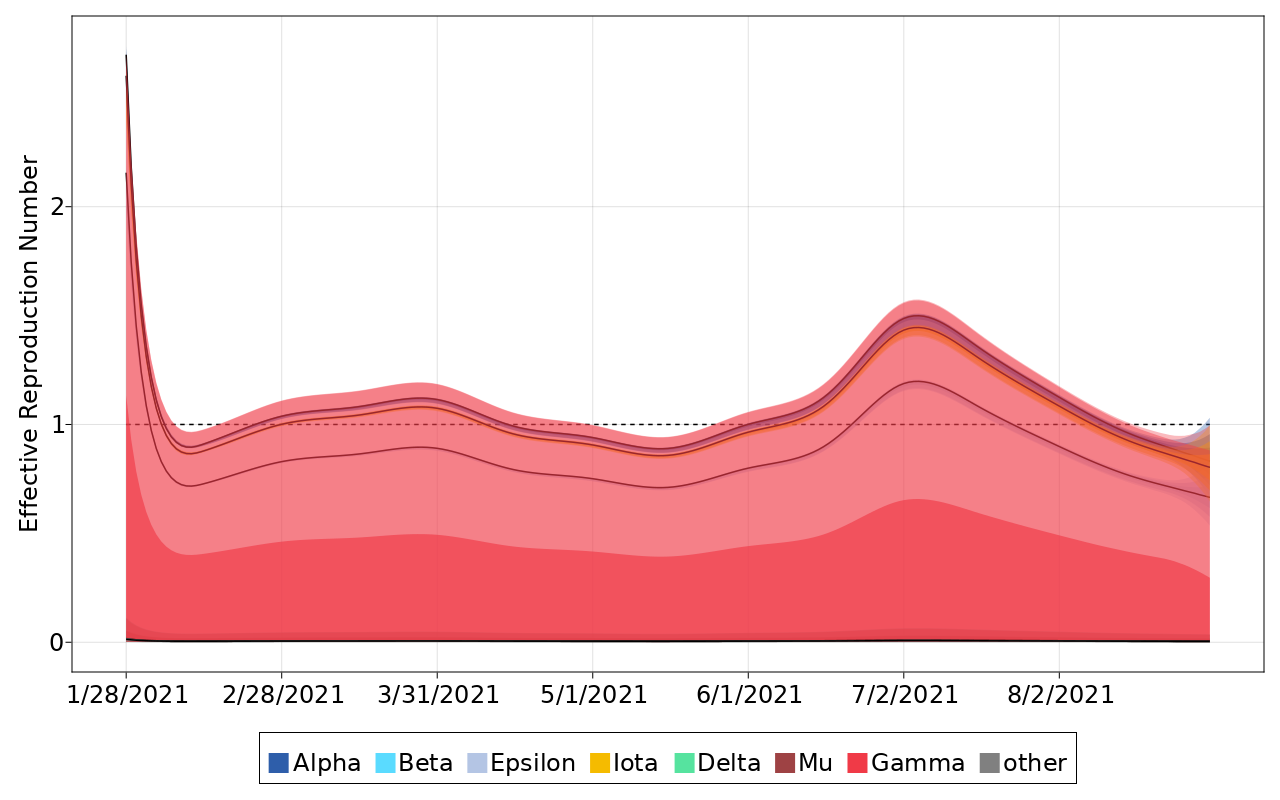

In [207]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1, 1] = Axis(fig,ylabel = "Effective Reproduction Number")

lines!(ax, dates_num, fill(1., length(dates_num)), color = "black", linestyle=:dash)  

for (lineage, name) in enumerate(seq_labels)
    this_color = lineage_colors[lineage_map[name]]
    
    # Plot credible intervals
    for i in reverse(1:length(ps))
        band!(ax, dates_num, 
            lQ[lineage][1:end,i], uQ[lineage][1:end,i], 
            color = (this_color, alphas[i]), 
            label = "$(Int(ps[i] * 100))% CI")
    end
    
    # Add median
    lines!(ax, dates_num, med[lineage][1:end,1], color = "black", label = "Median")
end

ax.xticks = 1:31:(length(dates_num)-1)
ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")

elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in seq_labels]
fig[2,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)

#save("lab-meeting-08-13-21-figs/$(SoI)-Lineage-Rt.png", fig)

fig

In [208]:
v = get_posterior(states_dict, SoI, "v", false)
v = vcat(hcat(v...)')
med = median(v, dims = 1)
lQ = vcat([quantile(vi, lQuants) for vi in eachcol(v)]...)
uQ = vcat([quantile(vi, uQuants) for vi in eachcol(v)]...)

7×3 Matrix{Float64}:
 5.7691    6.18312  6.18342
 0.735726  1.34843  2.06153
 5.5479    5.95926  5.96109
 5.73747   6.14773  6.15054
 0.755841  1.37315  2.09019
 0.682872  1.30422  2.02546
 4.14      4.91549  4.916

In [209]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1, 1] = Axis(fig,ylabel = "Inferred Transmission Advantage")

lines!(ax, [0.5, 5.5], [1.0, 1.0], color = :black, linestyle = :dash)
for (lineage, name) in enumerate(seq_labels[1:end-1])
    this_color = lineage_colors[lineage_map[name]]
    CairoMakie.violin!(ax, fill(lineage, size(v, 1)), exp.(v[:, lineage]), 
        color = this_color, 
        orientation=:vertical,
        width = 0.25,
        strokewidth = 1.5,
        strokecolor = :black)
    CairoMakie.scatter!(ax, fill(lineage, size(v, 1)), exp.(v[:, lineage]), color = (:black, 0.1))
end

ax.xticks = 1:5
ax.xtickformat = xs -> WHO_seq_names[convert.(Int,xs)]
CairoMakie.ylims!(ax, (0.9, 2.5))

elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in seq_labels]
fig[2,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)
#save("lab-meeting-08-13-21-figs/$(SoI)-Lineage-Transmission-Advantage.png", fig)
fig

LoadError: More than 1 intersections can't be handled currently. Found: [86, 317, 199, 204], Point{2, Float32}[[6.0, 18.293179], [6.0, 43.449383]]

In [210]:
sim_freq = get_posterior(states_dict, SoI, "sim_freq", true)
lQ, uQ, med = sim_stats_multi(sim_freq, lQuants, uQuants)
lQ, uQ, med = parse_by_deme(lQ, uQ, med)

([[0.0251755 0.02451121 0.02372373; 0.026836449999999998 0.02614632 0.02532645; … ; 0.7917235 0.3757423 0.36740585000000003; 0.7912655 0.3726569 0.36428105], [0.005366655 0.00360228 0.002453159; 0.0052179425 0.003502968 0.002396177; … ; 6.0607475e-76 4.0386919999999994e-81 7.928987499999998e-87; 2.71725e-76 1.7075019999999999e-81 3.2002954999999987e-87], [0.32188399999999995 0.31331 0.303730075; 0.3369475 0.32828680000000005 0.318594625; … ; 0.0010160745 0.0006250062 0.000573455575; 0.0009741285000000001 0.0005957318 0.0005461107], [0.0058765925 0.0056197650000000005 0.005328243; 0.0062391174999999995 0.005967062 0.00566690475; … ; 0.03603985 0.02483389 0.021503144999999998; 0.03560175 0.02449409 0.02120683], [0.0056536225 0.0038497999999999996 0.0026094135; 0.0054993825 0.003748076 0.0025409557499999997; … ; 1.1613075e-75 7.007360999999995e-81 2.0780857499999987e-86; 5.1730124999999997e-76 2.940117999999998e-81 8.299250749999995e-87], [0.0009601865 0.0004755721 0.00021868655; 0.000934

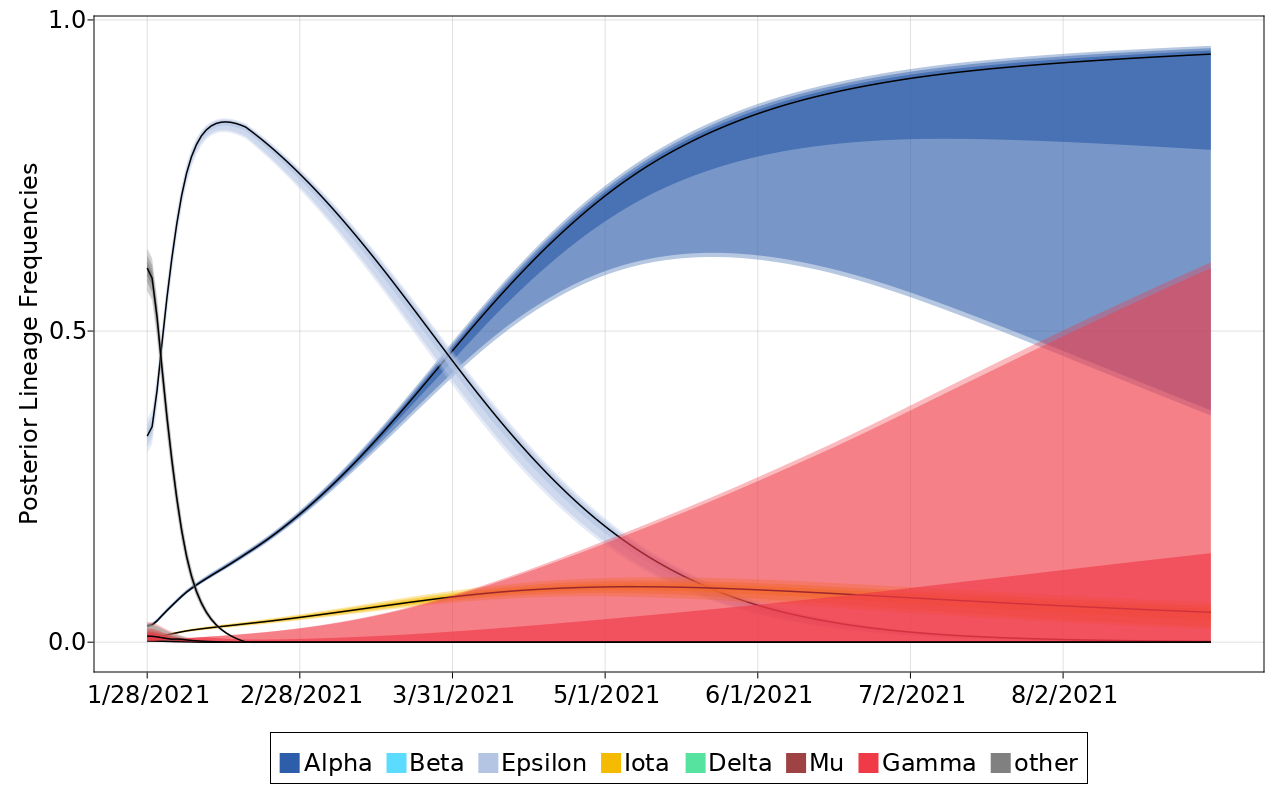

In [211]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1, 1] = Axis(fig,ylabel = "Posterior Lineage Frequencies")

for (lineage, name) in enumerate(seq_labels)
    this_color = lineage_colors[lineage_map[name]]
    
    # Plot credible intervals
    for i in reverse(1:length(ps))
        band!(ax, dates_num, 
            lQ[lineage][:,i], uQ[lineage][:,i], 
            color = (this_color, alphas[i]), 
            label = "$(Int(ps[i] * 100))% CI")
    end
    
    # Add median
    lines!(ax, dates_num, med[lineage][:,1], color = "black", linewidth = 1.5, label = "Median")
end

ax.xticks = 1:31:(length(dates_num)-1)
ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")

elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in seq_labels]
fig[2,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)
#save("lab-meeting-08-13-21-figs/$(SoI)-Lineage-Frequencies.png", fig)

fig

In [212]:
sample_freq = states_dict[SoI]["stan_data"]["num_sequenced"] ./ sum(states_dict[SoI]["stan_data"]["num_sequenced"], dims = 2)

obs_freq = get_posterior(states_dict, SoI, "obs_freq", true)
lQ, uQ, med = sim_stats_multi(obs_freq, lQuants, uQuants)
lQ, uQ, med = parse_by_deme(lQ, uQ, med)

([[0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.679245 0.339623 0.188679; 0.6667805 0.328767 0.175342], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.218579 0.144418 0.0811866; 0.238636 0.153409 0.09086175249999999; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.00269542 0.0 0.0; 0.00273973 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.487119 0.387978 0.278669475; 0.469697 0.367424 0.257576; … ; 0.0 0.0 0.0; 0.0 0.0 0.0]], [[0.030445 0.0835285 0.17722452500000008; 0.030303 0.0833333 0.176136; … ; 0.990566 0.998652 1.0; 0.990411 0.99863 1.0], [0.00234192 0.0273224 0.11165150000000007; 0.00189394 0.0246212 0.0984848; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.42701 0.533958 0.6456475500000002; 0.458333 0.5625 0.6705023250000002; … ; 0.0 0.0 0.005424532500000123; 0.0 0.0 0.00684932], [0.0 0.0124902 0.078064; 0.0 0.0132576 0.0814867475000001

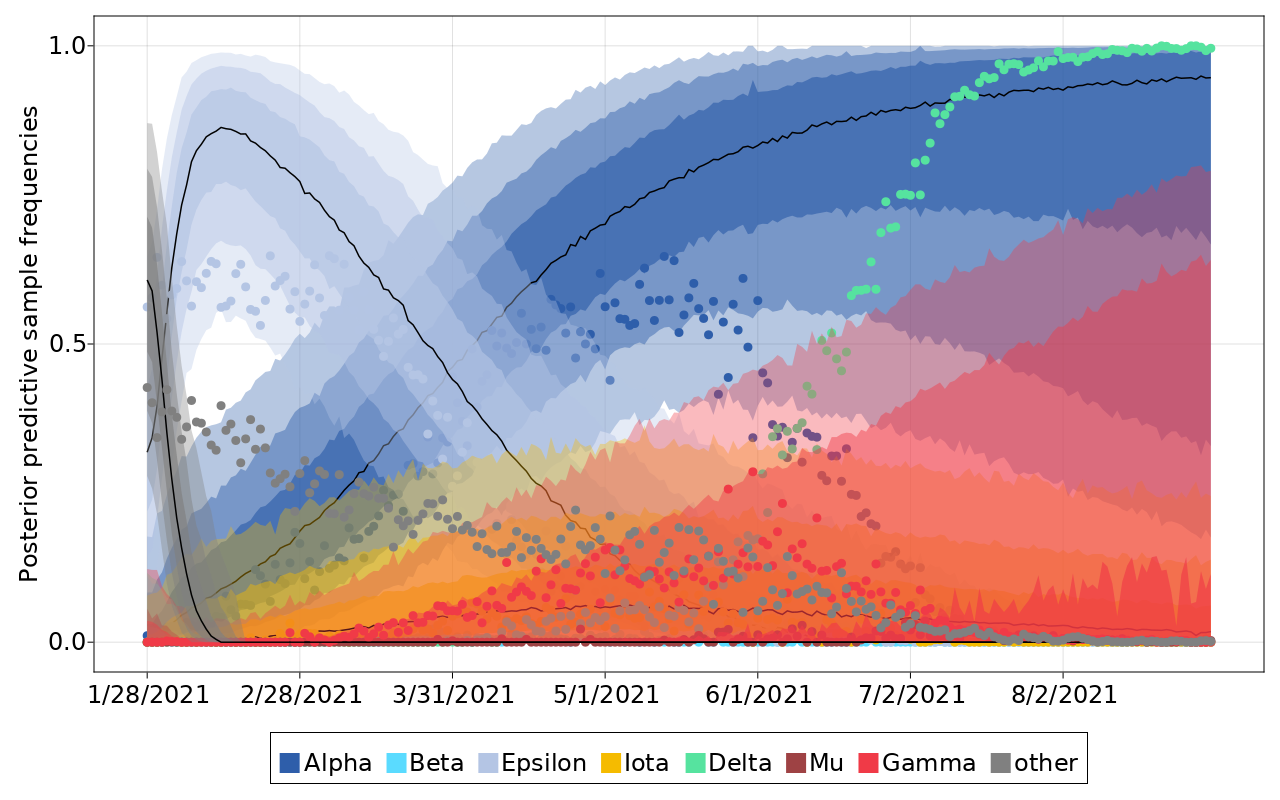

In [213]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1, 1] = Axis(fig,ylabel = "Posterior predictive sample frequencies")

for (lineage, name) in enumerate(seq_labels)
    this_color = lineage_colors[lineage_map[name]]
    
    # Plot credible intervals
    for i in reverse(1:length(ps))
        band!(ax, dates_num, 
            lQ[lineage][:,i], uQ[lineage][:,i], 
            color = (this_color, alphas[i]), 
            label = "$(Int(ps[i] * 100))% CI")
    end
    
    # Add median
    lines!(ax, dates_num, med[lineage][:,1], color = "black", linewidth = 1.5, label = "Median")
    CairoMakie.scatter!(ax, dates_num,sample_freq[:,lineage],
        color = (this_color, 1.0))
end

ax.xticks = 1:31:(length(dates_num)-1)
ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")

elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in seq_labels]
fig[2,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)

#save("lab-meeting-08-13-21-figs/$(SoI)-Lineage-Post-Pred-Frequencies.png", fig)
fig

In [133]:
lin_prev = get_posterior(states_dict, SoI, "lineage_prev.", true)
lQ, uQ, med = sim_stats_multi(lin_prev, lQuants, uQuants)
lQ, uQ, med = parse_by_deme(lQ, uQ, med)

([[1574.2350000000001 1484.042 1382.112; 1577.585 1487.1680000000001 1387.2355; … ; 35.4259 32.6534 29.677712500000002; 31.955525 29.38831 26.728337500000002], [50.205 43.16909 35.5027075; 50.2632 43.22389 35.6903625; … ; 0.1203405 0.09305002 0.068156355; 0.107361 0.08251171 0.060812992499999996], [22040.375 20948.49 19739.805; 21950.5 20848.08 19663.997499999998; … ; 0.036536624999999996 0.03209281 0.02784532; 0.0316251 0.02774557 0.024047475], [131.14 118.7651 107.75305; 131.367 119.1755 108.0214; … ; 3.0084625 2.658642 2.302319; 2.7104425 2.397163 2.06811925], [0.049972050000000004 0.04285978 0.035800370000000005; 0.050835425 0.04363256 0.036525709999999996; … ; 21625.675 20604.16 19483.74; 20989.35 19950.32 18870.0625], [0.040727725 0.030633569999999995 0.0219538175; 0.041270225 0.0310112 0.0222989725; … ; 82.7367 73.50980999999999 64.987345; 78.429675 69.42313 61.39394], [79.828625 73.52286000000001 66.268635; 80.181225 73.91491 66.6636125; … ; 42.871575 39.30066 35.52713999999999

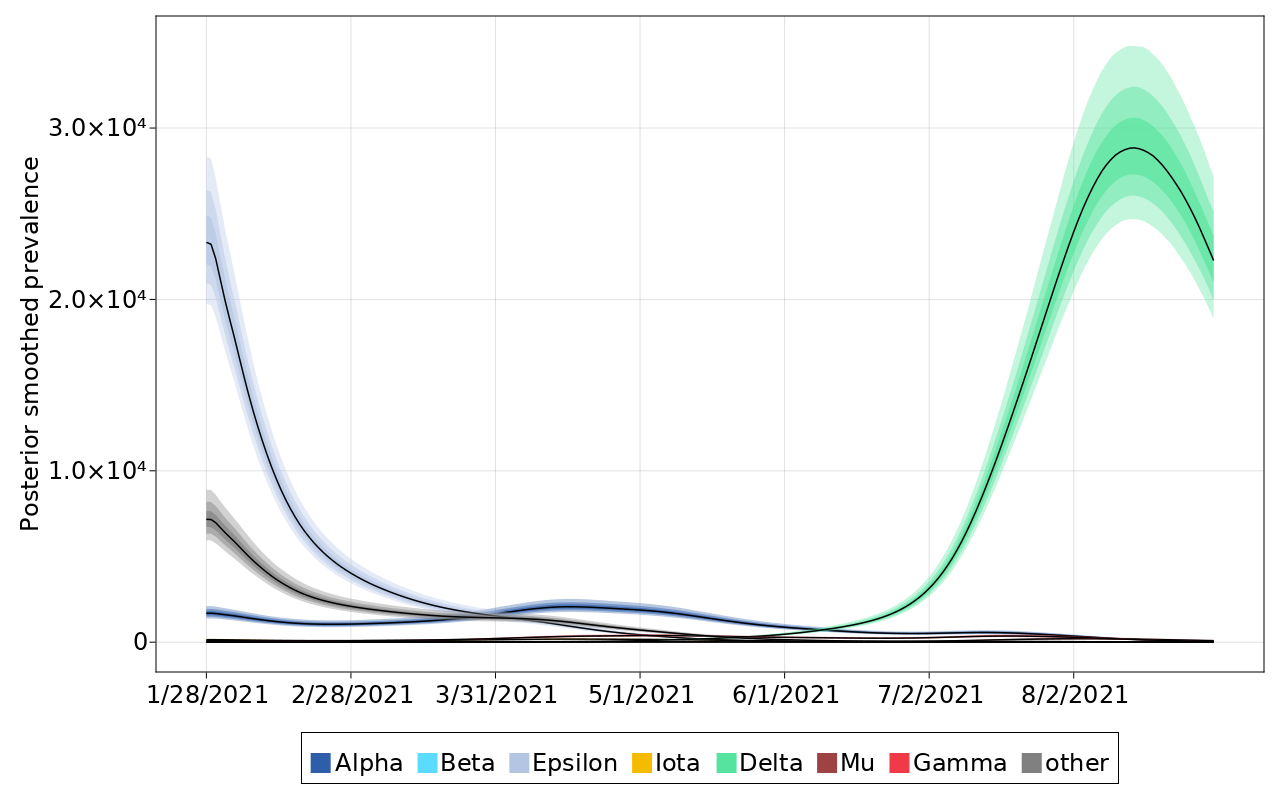

In [134]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1, 1] = Axis(fig,ylabel = "Posterior smoothed prevalence")

for (lineage, name) in enumerate(seq_labels)
    this_color = lineage_colors[lineage_map[name]]
    
    # Plot credible intervals
    for i in reverse(1:length(ps))
        band!(ax, dates_num, 
            lQ[lineage][:,i], uQ[lineage][:,i], 
            color = (this_color, alphas[i]), 
            label = "$(Int(ps[i] * 100))% CI")
    end
    
    # Add median
    lines!(ax, dates_num, med[lineage][:,1], color = "black", linewidth = 1.5, label = "Median")
end

ax.xticks = 1:31:(length(dates_num)-1)
ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")

elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in seq_labels]
fig[2,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)

#save("lab-meeting-08-13-21-figs/$(SoI)-Lineage-Post-Cases.png", fig)
fig

In [412]:
#mean_rho =  mean.(get_posterior(states_dict, SoI, "rho.", false))
#scaled_prev = [lin_prev[i] .* mean_rho[i] for i in 1:length(mean_rho)]
scaled_prev = get_posterior(states_dict, SoI, "scaled_prev.", true)
lQ, uQ, med = sim_stats_multi(scaled_prev, lQuants, uQuants)
lQ, uQ, med = parse_by_deme(lQ, uQ, med)

([[105.21175 96.54733 88.5231975; 105.49275 96.99105999999999 88.9473675; … ; 21.534325000000003 19.770770000000002 18.054195; 20.469749999999998 18.56291 16.7176725], [5.3496825 4.641432 3.9591005; 5.3558475 4.6509 3.9725325; … ; 0.22838825000000001 0.19580619999999999 0.161184425; 0.215735 0.1840151 0.150863375], [616.00825 563.969 519.2819; 614.52475 562.8178 520.044725; … ; 0.11820025 0.1072796 0.0955593925; 0.10846399999999999 0.097669 0.0867347975], [9.9613225 8.841471 7.77303225; 9.9737975 8.871621000000001 7.829698; … ; 1.0634625 0.9539421 0.847352075; 1.0071675 0.8962768999999999 0.7844162499999999], [0.0009043235 0.0007908848 0.00066952485; 0.00092036075 0.0008078706999999999 0.00068476155; … ; 2811.895 2580.7000000000003 2337.74825; 2889.89 2614.703 2337.4627499999997], [9.1578625 8.294646 7.457356; 9.19318 8.342848 7.53202225; … ; 14.608225 13.346400000000001 12.0171925; 14.000425 12.647319999999999 11.254355], [928.49425 853.7728000000001 789.1294; 924.7987499999999 853.04

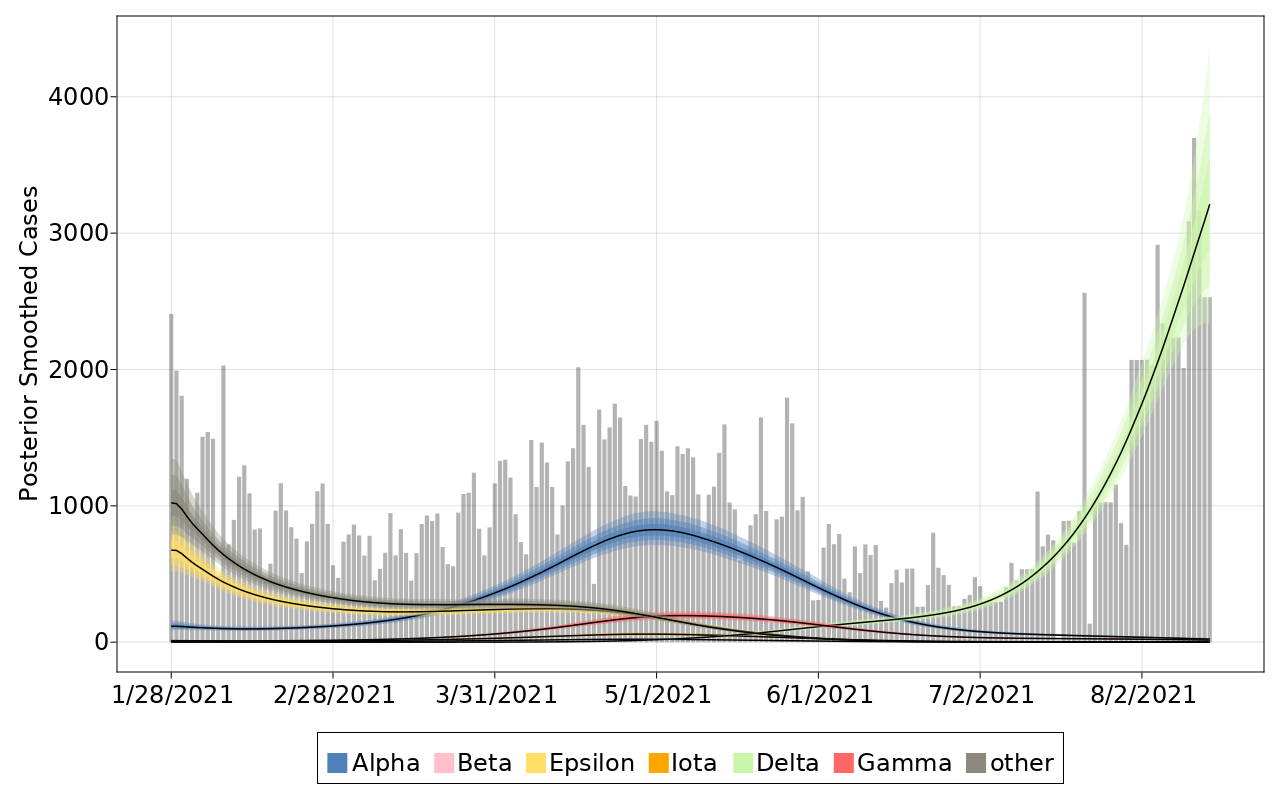

In [413]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1, 1] = Axis(fig,ylabel = "Posterior Smoothed Cases")
    
barplot!(ax, dates_num, states_dict[SoI]["stan_data"]["cases"], color = (:black, 0.3))

for (lineage, name) in enumerate(seq_labels)
    this_color = lineage_colors[lineage_map[name]]
    
    # Plot credible intervals
    for i in reverse(1:length(ps))
        band!(ax, dates_num, 
            lQ[lineage][:,i], uQ[lineage][:,i], 
            color = (this_color, alphas[i]), 
            label = "$(Int(ps[i] * 100))% CI")
    end
    
    # Add median
    lines!(ax, dates_num, med[lineage][:,1], color = "black", linewidth = 1.5, label = "Median")
end

ax.xticks = 1:31:(length(dates_num)-1)
ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")

elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in seq_labels]
fig[2,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)

fig

In [143]:
sample_counts = states_dict[SoI]["stan_data"]["num_sequenced"]
obs_counts = get_posterior(states_dict, SoI, "obs_counts", true)
lQ, uQ, med = sim_stats_multi(obs_counts, lQuants, uQuants)
lQ, uQ, med = parse_by_deme(lQ, uQ, med)

([[43.0 30.0 18.0; 17.0 12.0 7.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], [876.0 836.0 789.0; 361.0 342.0 321.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 734.0 726.0 714.0; 722.0 715.0 704.0], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], [240.0 207.0 174.0; 98.0 84.0 69.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0]], [[86.0 111.0 142.0250000000001; 35.25 46.0 60.0; … ; 1.0 4.0 11.0; 1.0 3.0 10.0], [2.0 8.0 20.0; 1.0 3.0 8.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], [967.0 1004.0 1040.0; 399.0 415.0 432.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], [7.0 16.0 30.0; 3.0 7.0 15.0; … ; 0.0 0.0 1.0; 0.0 0.0 1.0], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 741.0 742.0 742.0; 729.0 730.0 730.0], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 4.0 9.0 19.0; 4.0 9.0 19.0], [3.0 11.0 26.0; 1.0 5.0 11.0; … ; 1.0 4.0 12.0; 1.0 4.0 13.0], [321.0 362.0 407.0; 133.0 15

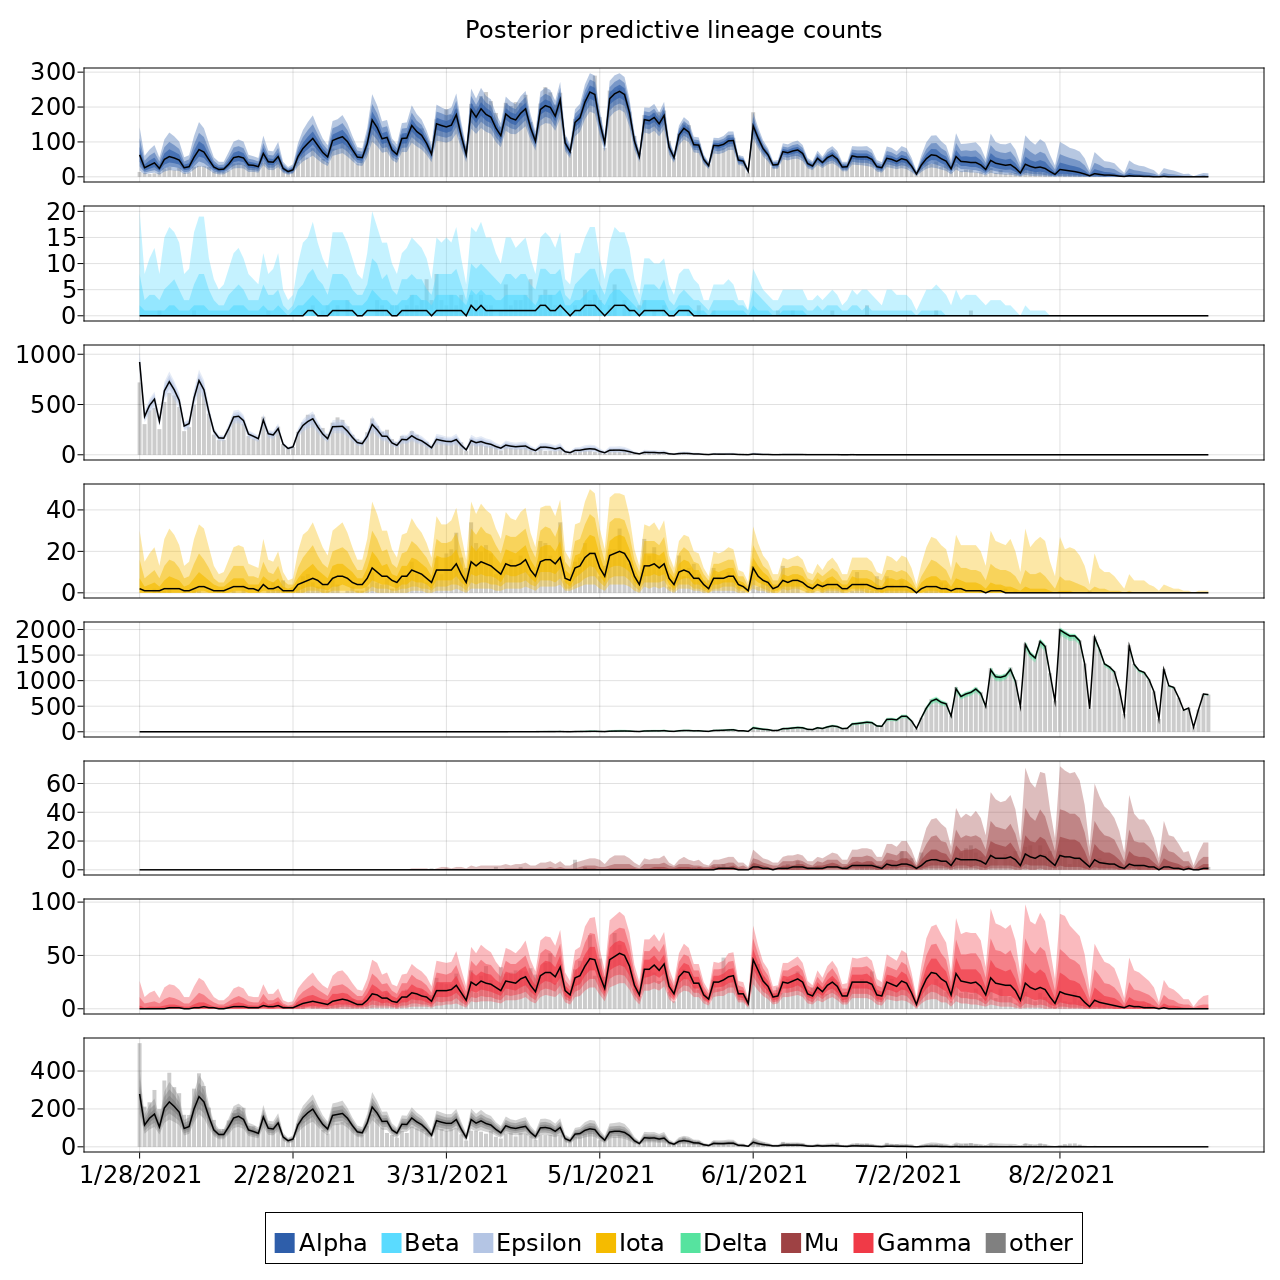

In [144]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 1280), fontsize = 24)
supertitle = fig[1, 1] = Label(fig, "Posterior predictive lineage counts",
    textsize = 24, color = :black, orientation = :horizontal, tellwidth = false, tellheight = true)

ax = []
for i in 1:length(seq_labels)
    ax_now = Axis(fig)
    push!(ax, ax_now)
    fig[i+1, 1] = ax_now
    ax_now.xticks = 1:31:(length(dates_num)-1)
    ax_now.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")
end

for (lineage, name) in enumerate(seq_labels)
    this_color = lineage_colors[lineage_map[name]]
    
    CairoMakie.barplot!(ax[lineage], dates_num,sample_counts[:,lineage],
        color = (:black, 0.2))
    
    # Plot credible intervals
    for i in reverse(1:length(ps))
        band!(ax[lineage], dates_num, 
            lQ[lineage][:,i], uQ[lineage][:,i], 
            color = (this_color, alphas[i]), 
            label = "$(Int(ps[i] * 100))% CI")
    end
    
    # Add median
    lines!(ax[lineage], dates_num, med[lineage][:,1], color = "black", linewidth = 1.5, label = "Median")
    
  if lineage != length(seq_labels)
        hidexdecorations!(ax[lineage], grid = false) 
    end
end

elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in seq_labels]
fig[length(seq_labels)+2,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)

#save("lab-meeting-08-13-21-figs/$(SoI)-Lineage-Post-Pred-Counts.png", fig)

fig

In [145]:
total_prev = get_posterior(states_dict, SoI, "total_prev.", false)
total_prev = vcat(hcat(total_prev...))
#med = median(total_prev, dims = 2)
#lQ = vcat([quantile(vi, lQuants) for vi in eachrow(total_prev)]...)
#uQ = vcat([quantile(vi, uQuants) for vi in eachrow(total_prev)]...)
#ρ_mean = mean(reduce(vcat, get_posterior(states_dict, SoI, "rho.", false)))
mean_rho =  mean.(get_posterior(states_dict, SoI, "rho.", false))
scaled_prev = total_prev .* mean_rho'
med = median(scaled_prev, dims = 2)
lQ = vcat([quantile(vi, lQuants) for vi in eachrow(scaled_prev)]...)
uQ = vcat([quantile(vi, uQuants) for vi in eachrow(scaled_prev)]...)

231×3 Matrix{Float64}:
     0.0        0.0        0.0
   546.047    555.465    566.397
  2663.3     2709.24    2762.55
  5495.84    5590.63    5700.69
  8138.15    8278.51    8441.43
 10270.0    10447.1    10652.7
 11882.0    12087.0    12324.8
 13065.3    13290.6    13552.2
 13923.1    14163.2    14442.0
 14542.8    14793.7    15084.8
 14991.2    15249.8    15549.9
 15317.0    15581.2    15887.9
 15555.1    15823.4    16134.8
     ⋮                 
 13655.2    13795.3    13949.1
 13485.1    13625.0    13787.4
 13297.4    13436.3    13605.9
 13091.8    13229.9    13402.1
 12863.9    13003.7    13168.9
 12621.7    12754.0    12910.0
 12367.5    12497.5    12643.1
 12089.0    12230.7    12381.0
 11811.2    11956.1    12119.8
 11526.2    11687.0    11884.0
 11254.1    11442.5    11665.9
 10980.8    11219.0    11496.5

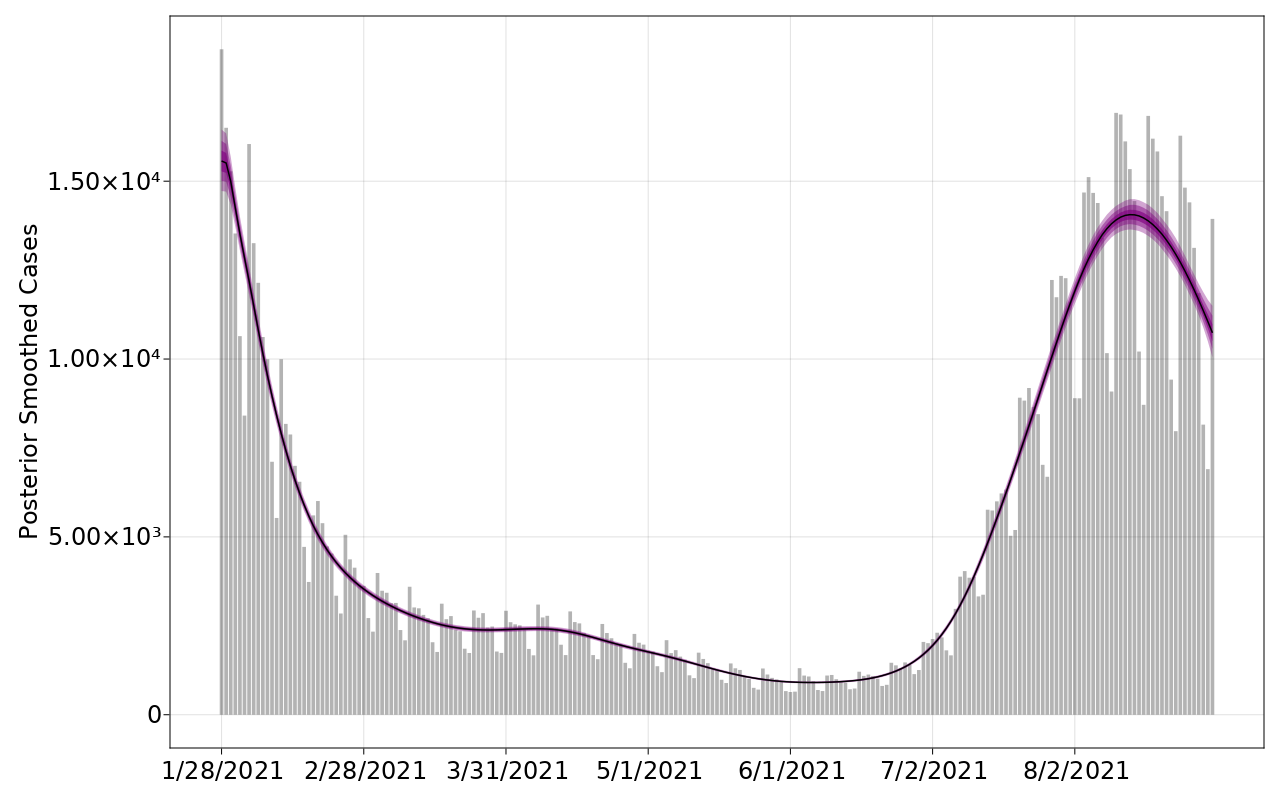

In [146]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1, 1] = Axis(fig,ylabel = "Posterior Smoothed Cases")
    
barplot!(ax, dates_num, states_dict[SoI]["stan_data"]["cases"], color = (:black, 0.3))
# Plot credible intervals
for i in reverse(1:length(ps))
    band!(ax, dates_num, 
        lQ[(seed_L+1):end,i],  uQ[(seed_L+1):end,i], 
        color = (:purple, alphas[i]), 
        label = "$(Int(ps[i] * 100))% CI")
end

# Add median
lines!(ax, dates_num, med[(seed_L+1):end,1], color = "black", linewidth = 1.5, label = "Median")

#
ax.xticks = 1:31:(length(dates_num)-1)
ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")

#save("lab-meeting-08-13-21-figs/$(SoI)-Lineage-Post-Smooth-Prev.png", fig)
fig

In [147]:
EC = get_posterior(states_dict, SoI, "EC.", false)
EC = vcat(hcat(EC...))
med = median(EC, dims = 2)
lQ = vcat([quantile(vi, lQuants) for vi in eachrow(EC)]...)
uQ = vcat([quantile(vi, uQuants) for vi in eachrow(EC)]...)

217×3 Matrix{Float64}:
 18238.1   18553.7   18960.7
 17706.6   18015.5   18366.0
 15958.9   16209.4   16484.6
 14555.9   14746.1   14962.5
 10498.7   10631.8   10780.3
  9096.96   9213.89   9344.12
 14987.3   15163.0   15365.2
 13398.8   13544.0   13726.4
 12275.5   12407.7   12580.8
 10766.5   10893.0   11048.1
  9722.11   9831.02   9957.53
  6949.44   7035.79   7125.43
  5956.49   6022.73   6101.73
     ⋮               
 14321.0   14475.8   14685.8
 13597.4   13748.5   13943.5
 10206.8   10328.3   10484.0
  9160.39   9278.2    9404.94
 15637.2   15823.2   16052.5
 14531.7   14701.9   14888.7
 13867.3   14038.4   14236.8
 12676.1   12836.4   13022.6
 11904.8   12075.0   12254.1
  8840.0    8974.86   9146.2
  7865.43   8004.92   8171.48
 13326.9   13617.1   13979.0

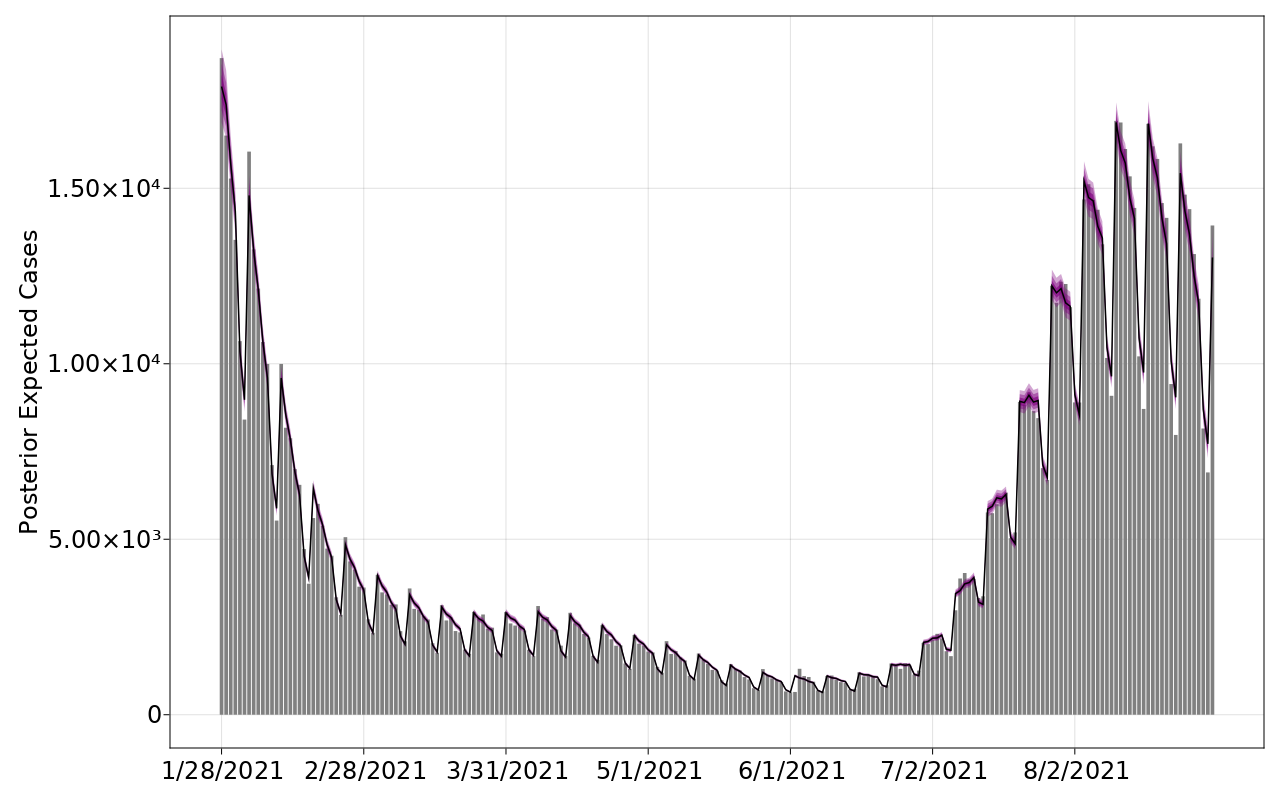

In [148]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1, 1] = Axis(fig,ylabel = "Posterior Expected Cases")
    
barplot!(ax, dates_num, states_dict[SoI]["stan_data"]["cases"], color = "grey")
# Plot credible intervals
for i in reverse(1:length(ps))
    band!(ax, dates_num, 
        lQ[:,i],  uQ[:,i], 
        color = (:purple, alphas[i]), 
        label = "$(Int(ps[i] * 100))% CI")
end

# Add median
lines!(ax, dates_num,med[:,1], color = "black", linewidth = 1.5, label = "Median")

#
ax.xticks = 1:31:(length(dates_num)-1)
ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")
#save("lab-meeting-08-13-21-figs/$(SoI)-Lineage-Post-Pred-Total-Cases.png", fig)

fig

In [149]:
R_average = get_posterior(states_dict, SoI, "R_average", false)
R_average = vcat(hcat(R_average...))
med = median(R_average, dims = 2)
lQ = vcat([quantile(vi, lQuants) for vi in eachrow(R_average)]...)
uQ = vcat([quantile(vi, uQuants) for vi in eachrow(R_average)]...)

217×3 Matrix{Float64}:
 0.750675  0.787076  0.841962
 0.736945  0.761297  0.797086
 0.725986  0.743622  0.76466
 0.718832  0.731744  0.746207
 0.714529  0.724545  0.73828
 0.712094  0.721761  0.733547
 0.710832  0.720523  0.73084
 0.711238  0.719521  0.729639
 0.712591  0.719624  0.729996
 0.714847  0.722172  0.730892
 0.718607  0.725978  0.734354
 0.723707  0.731003  0.739594
 0.729857  0.73747   0.746055
 ⋮                   
 0.930836  0.939951  0.950601
 0.922618  0.931675  0.94353
 0.914905  0.925044  0.93771
 0.907832  0.919253  0.932877
 0.901299  0.914678  0.928628
 0.895348  0.91023   0.927718
 0.890923  0.907905  0.927806
 0.888029  0.909531  0.933839
 0.887528  0.914428  0.948437
 0.889488  0.926174  0.974241
 0.893526  0.942809  1.01474
 0.902867  0.968304  1.06999

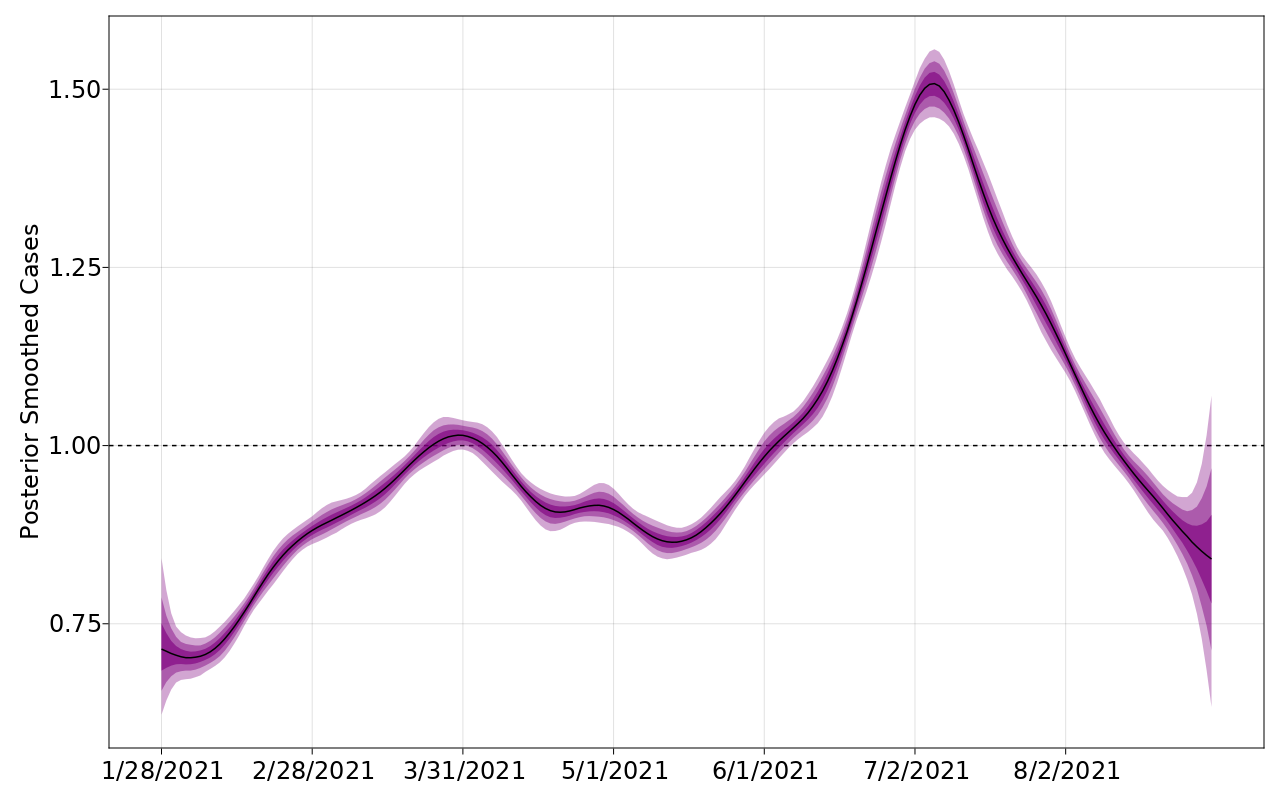

In [150]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1, 1] = Axis(fig,ylabel = "Posterior Smoothed Cases")


hlines!(ax, [1], linestyle = :dash, color = :black)
  
# Plot credible intervals
for i in reverse(1:length(ps))
    band!(ax, dates_num, 
        lQ[:,i],  uQ[:,i], 
        color = (:purple, alphas[i]), 
        label = "$(Int(ps[i] * 100))% CI")
end
# Add median
lines!(ax, dates_num, med[:,1], color = "black", linewidth = 1.5, label = "Median")

#
ax.xticks = 1:31:(length(dates_num)-1)
ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")

fig

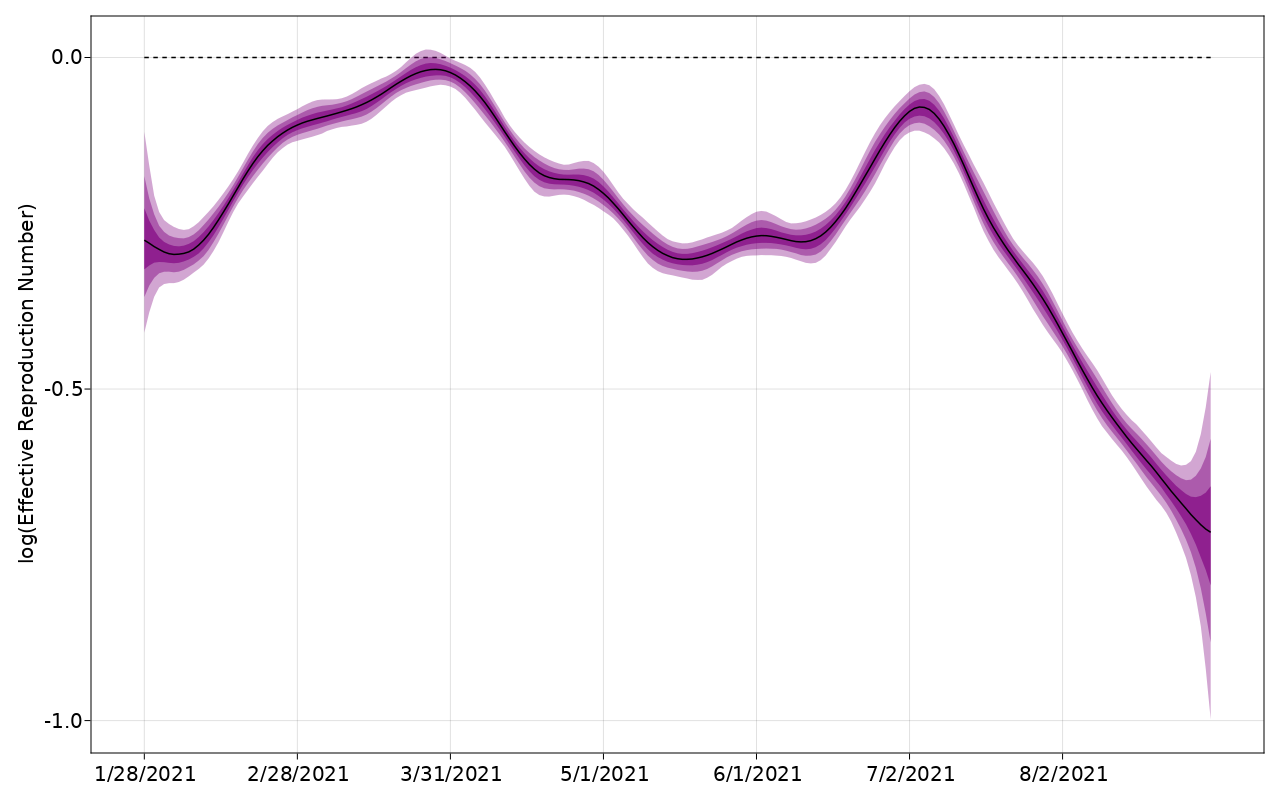

In [151]:
R_base = get_posterior(states_dict, SoI, "R.", true)
R_base = [ log.(x) for x in R_base]
lQ, uQ, med = sim_stats_multi(R_base, lQuants, uQuants)
lQ, uQ, med = parse_by_deme(lQ, uQ, med)


fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 20)
ax = fig[1, 1] = Axis(fig,ylabel = "log(Effective Reproduction Number)")

lines!(ax, dates_num, fill(0., length(dates_num)), color = "black", linestyle=:dash)  

# Plot credible intervals
for i in reverse(1:length(ps))
    band!(ax, dates_num, 
        lQ[end][1:end,i],  uQ[end][1:end,i], 
        color = (:purple, alphas[i]), 
        label = "$(Int(ps[i] * 100))% CI")
end

# Add median
lines!(ax, dates_num, med[end][1:end,1], color = "black", linewidth = 1.5, label = "Median")

ax.xticks = 1:31:(length(dates_num)-1)
ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")

fig

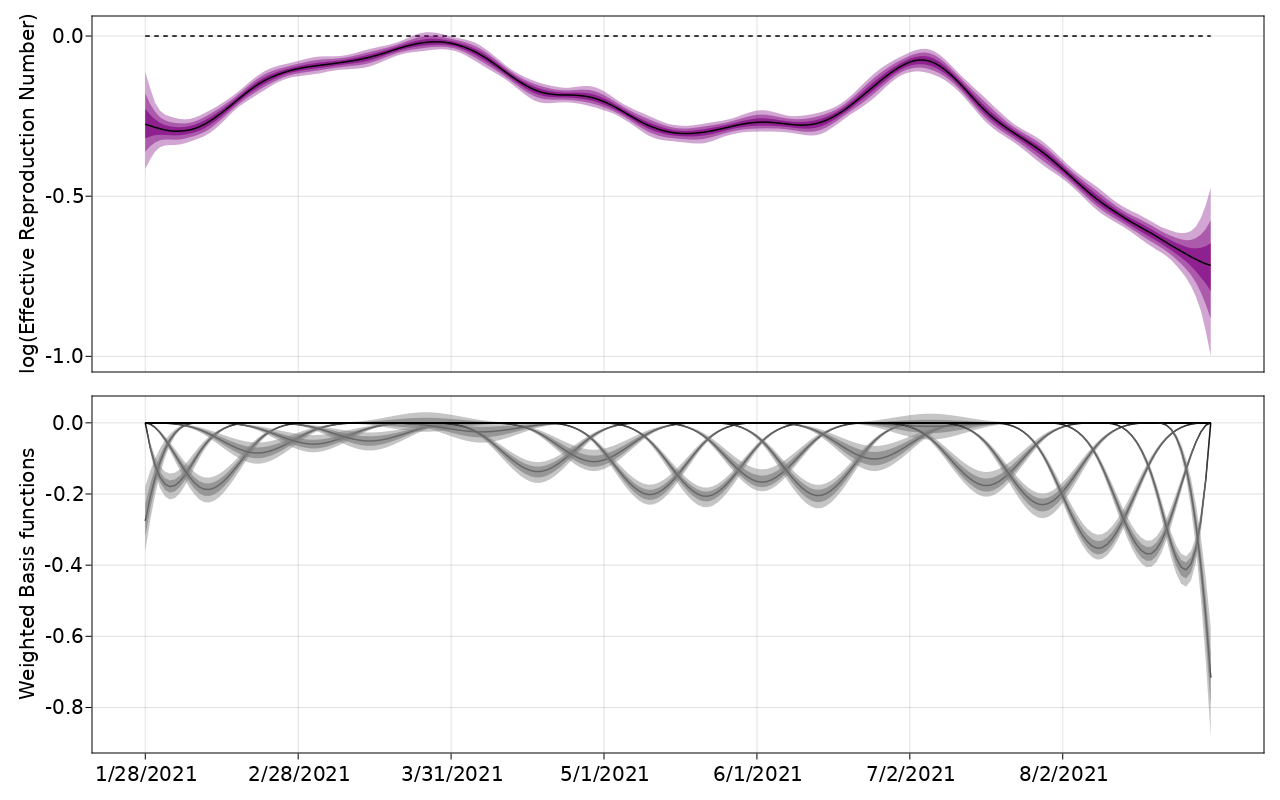

In [152]:
hidexdecorations!(ax, grid = false)

b_post = get_posterior(states_dict, SoI, "b.", false)
b_post = vcat(hcat(b_post...))
med = median(b_post, dims = 2)
lQ = vcat([quantile(vi, lQuants) for vi in eachrow(b_post)]...)
uQ = vcat([quantile(vi, uQuants) for vi in eachrow(b_post)]...)

features = states_dict[SoI]["stan_data"]["features"]
feature_lQ = [lQ[:,i]' .* features for i in 1:length(ps)]
feature_uQ = [uQ[:,i]' .* features for i in 1:length(ps)]
feature_med = (med' .* features)

ax = fig[2, 1] = Axis(fig, ylabel = "Weighted Basis functions")

for i in 1:size(feature_med,2)
    lines!(ax, dates_num,feature_med[1:end,i] , color = :black)
    for q in 1:2
    band!(ax, dates_num, 
            feature_lQ[q][1:end,i],  feature_uQ[q][1:end,i], 
        color = ("grey", alphas[q]), 
        label = "$(Int(ps[q] * 100))% CI")
    end
end

ax.xticks = 1:31:length(dates_num)
ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs )], "m/d/Y")
#save("lab-meeting-08-13-21-figs/$(SoI)-Lineage-Rt-with-basis.png", fig)

fig

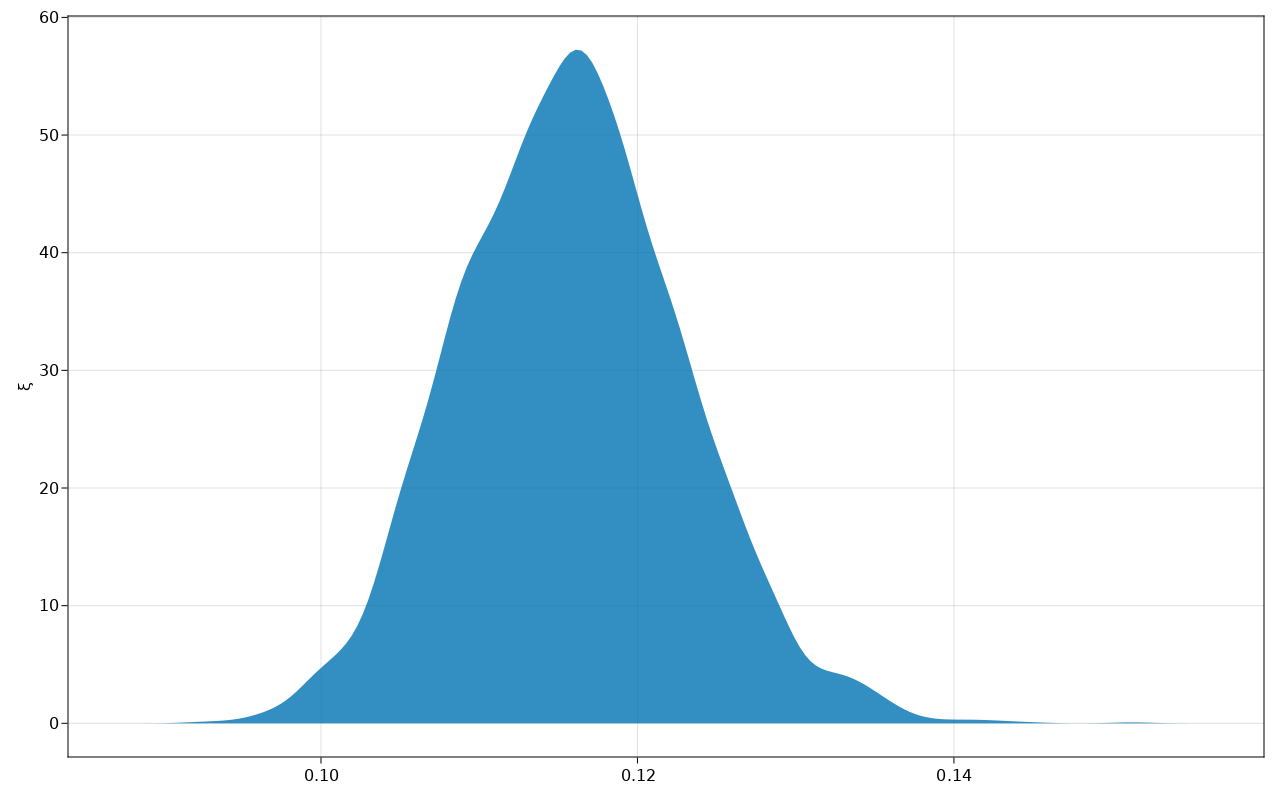

In [153]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800))
ax = fig[1, 1] = Axis(fig,ylabel = "ξ")
CairoMakie.density!(ax, reduce(vcat, get_posterior(states_dict, SoI, "xi", false)))
fig

## Running all

In [431]:
# Get Rt by state
lQuants = [0.25  0.1]
uQuants = [0.75 0.90]

lQuants = [0.25 0.1 0.025]
uQuants = [0.75 0.9 0.975]

function get_Rt_by_state(state, states_dict)
    N_lineages = states_dict[state]["stan_data"]["N_lineage"]
    seq_labels = states_dict[state]["seq_labels"]
    
    # Process Rt 
    R = sample_posterior(states_dict[state]["stan_results"], states_dict[state]["stan_cnames"], N_lineages, "R.")
    lQ, uQ, med = sim_stats_multi(R, lQuants, uQuants)
    lQ, uQ, med = parse_by_deme(lQ, uQ, med)
    
    sim_freq = sample_posterior(states_dict[state]["stan_results"], states_dict[state]["stan_cnames"], N_lineages, "sim_freq")
    lQ_, uQ_, med_ = sim_stats_multi(sim_freq, lQuants, uQuants)
    _, _, freq_med = parse_by_deme(lQ_, uQ_, med_)
    
    dates_vec = [] 
    state_vec = []
    lineage_vec = []
    rt_median = []
    rt_lower = []
    rt_upper = []
    freq_median = []

    # May have to adjust to the size of things
    seed_L = states_dict[state]["stan_data"]["seed_L"]
    for lineage in 1:N_lineages
        dates_vec = vcat(dates_vec, states_dict[state]["date"])
        state_vec = vcat(state_vec, repeat([state], length(states_dict[state]["date"])))
        lineage_vec = vcat(lineage_vec, repeat([seq_labels[lineage]], length(states_dict[state]["date"])))
        rt_median = vcat(rt_median, med[lineage][1:end, 1])
        push!(rt_lower, lQ[lineage][1:end, :])
        push!(rt_upper, uQ[lineage][1:end, :])
        freq_median = vcat(freq_median, freq_med[lineage][1:end, 1])
    end
    
    rt_lower = vcat(rt_lower...)
    rt_upper = vcat(rt_upper...)

    return DataFrame(state = state_vec, 
        date = dates_vec,
        lineage = lineage_vec,
        rt_median = rt_median,
        rt_lower_50 = rt_lower[:, 1],
        rt_upper_50 = rt_upper[:, 1],
        rt_lower_80 = rt_lower[:, 2],
        rt_upper_80 = rt_upper[:, 2],
        rt_lower_95 = rt_lower[:, 3],
        rt_upper_95 = rt_upper[:, 3],
        freq_median = freq_median)
end

df_list = []

Any[]

In [430]:
get_Rt_by_state(SoI, states_dict)

,state,date,lineage,rt_median,rt_lower_50,rt_upper_50,rt_lower_80
,Any,Any,Any,Any,Float64,Float64,Float64
1,Washington,2021-01-28,B.1.1.7,0.845109,0.749202,0.934566,0.65721
2,Washington,2021-01-29,B.1.1.7,0.857725,0.77523,0.933446,0.694964
3,Washington,2021-01-30,B.1.1.7,0.869073,0.799712,0.93788,0.729597
4,Washington,2021-01-31,B.1.1.7,0.883488,0.820538,0.943814,0.762746
5,Washington,2021-02-01,B.1.1.7,0.897054,0.84244,0.952101,0.788568
6,Washington,2021-02-02,B.1.1.7,0.91143,0.861571,0.962055,0.814547
7,Washington,2021-02-03,B.1.1.7,0.925013,0.879247,0.97242,0.837786
8,Washington,2021-02-04,B.1.1.7,0.938992,0.896679,0.981543,0.859422
9,Washington,2021-02-05,B.1.1.7,0.952683,0.913306,0.991366,0.880077


In [314]:
for state in sort(collect(keys(states_dict)))
    run_stan_model!(state, states_dict)
    state_rt = get_Rt_by_state(state, states_dict)
    CSV.write("../data/sims/results/inferred_lineage_rts_$(state)_09_02_2021.csv", state_rt)
    print("Saved state $(state) dataframe")
    push!(df_list, state_rt)
end

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[9] is 0, but must be positive finite! (in '/Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test-Alabama/rt-lineages-Alabama.stan', line 266, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[9] is 0, but must be positive finite! (in '/Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test-Alabama/rt-lineages-Alabama.stan', line 266, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained var

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[32] is 0, but must be positive finite! (in '/Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test-Alabama/rt-lineages-Alabama.stan', line 266, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[1] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test-Alabama/rt-lineages-Alabama.stan', line 266, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained 

Saved state Alabama dataframeInference for Stan model: rt_lineages_Alaska_model
4 chains: each with iter=(500,500,500,500); warmup=(0,0,0,0); thin=(1,1,1,1); 2000 iterations saved.

Warmup took (219, 322, 621, 268) seconds, 24 minutes total
Sampling took (72, 74, 91, 73) seconds, 5.2 minutes total

                          Mean     MCSE   StdDev        5%       50%       95%    N_Eff  N_Eff/s    R_hat

lp__                  -3.4e+03  3.9e-01  6.2e+00  -3.4e+03  -3.4e+03  -3.3e+03  2.6e+02  8.2e-01  1.0e+00
accept_stat__             0.92  2.7e-03  9.3e-02      0.74      0.95      1.00     1191  3.8e+00  1.0e+00
stepsize__               0.017  3.0e-03  4.2e-03     0.010     0.019     0.021      2.0  6.5e-03  1.5e+14
treedepth__                6.5  2.2e-01  1.5e+00       4.0       7.0       8.0       47  1.5e-01  1.0e+00
n_leapfrog__               173  3.7e+01  1.2e+02        19       140       484       11  3.6e-02  1.1e+00
divergent__               0.70  2.0e-02  4.6e-01      0.00     

R[80,2]                6.3e-01  5.9e-02  3.8e-01   1.0e-01   8.1e-01   1.1e+00  4.1e+01  1.3e-01  1.1e+00
R[80,3]                9.1e-01  1.7e-03  3.5e-02   8.5e-01   9.1e-01   9.6e-01  4.4e+02  1.4e+00  1.0e+00
R[80,4]                1.1e+00  2.9e-03  5.4e-02   1.0e+00   1.1e+00   1.2e+00  3.5e+02  1.1e+00  1.0e+00
R[80,5]                1.9e+00  4.7e-03  9.0e-02   1.8e+00   1.9e+00   2.1e+00  3.7e+02  1.2e+00  1.0e+00
R[80,6]                1.1e+00  2.3e-03  4.5e-02   1.1e+00   1.1e+00   1.2e+00  3.9e+02  1.3e+00  1.0e+00
R[80,7]                1.0e+00  1.6e-03  3.3e-02   9.5e-01   1.0e+00   1.1e+00  4.2e+02  1.4e+00  1.0e+00
R[81,1]                1.1e+00  1.9e-03  4.0e-02   1.1e+00   1.1e+00   1.2e+00  4.4e+02  1.4e+00  1.0e+00
R[81,2]                6.3e-01  5.8e-02  3.8e-01   1.0e-01   8.1e-01   1.1e+00  4.1e+01  1.3e-01  1.1e+00
R[81,3]                9.0e-01  1.6e-03  3.4e-02   8.5e-01   9.0e-01   9.6e-01  4.7e+02  1.5e+00  1.0e+00
R[81,4]                1.1e+00  2.7e-03  5.3e-

R[168,4]               9.3e-01  2.6e-03  5.0e-02   8.5e-01   9.3e-01   1.0e+00  3.5e+02  1.1e+00  1.0e+00
R[168,5]               1.6e+00  2.6e-03  5.7e-02   1.5e+00   1.6e+00   1.7e+00  4.9e+02  1.6e+00  1.0e+00
R[168,6]               9.6e-01  1.8e-03  4.3e-02   8.9e-01   9.6e-01   1.0e+00  5.7e+02  1.8e+00  1.0e+00
R[168,7]               8.4e-01  1.8e-03  3.6e-02   7.8e-01   8.4e-01   9.0e-01  4.3e+02  1.4e+00  1.0e+00
R[169,1]               9.7e-01  1.9e-03  4.1e-02   9.1e-01   9.7e-01   1.0e+00  4.7e+02  1.5e+00  1.0e+00
R[169,2]               5.4e-01  4.9e-02  3.2e-01   8.5e-02   6.9e-01   9.2e-01  4.2e+01  1.4e-01  1.1e+00
R[169,3]               7.7e-01  1.6e-03  3.6e-02   7.1e-01   7.6e-01   8.3e-01  4.8e+02  1.5e+00  1.0e+00
R[169,4]               9.4e-01  2.7e-03  5.0e-02   8.6e-01   9.4e-01   1.0e+00  3.5e+02  1.1e+00  1.0e+00
R[169,5]               1.6e+00  2.5e-03  5.6e-02   1.5e+00   1.6e+00   1.7e+00  5.0e+02  1.6e+00  1.0e+00
R[169,6]               9.7e-01  1.8e-03  4.4e-

I[14,1]                1.4e+00  1.8e-02  3.4e-01   9.0e-01   1.4e+00   2.0e+00  3.6e+02  1.2e+00  1.0e+00
I[14,2]                3.6e-01  1.0e-02  3.9e-01   1.9e-02   2.4e-01   1.1e+00  1.4e+03  4.5e+00  1.0e+00
I[14,3]                1.4e+01  1.7e-01  2.5e+00   9.7e+00   1.3e+01   1.8e+01  2.2e+02  7.2e-01  1.0e+00
I[14,4]                1.8e-01  7.3e-03  1.3e-01   4.4e-02   1.6e-01   4.1e-01  3.0e+02  9.6e-01  1.0e+00
I[14,5]                2.7e-06  1.3e-07  2.9e-06   3.3e-07   1.8e-06   8.1e-06  5.0e+02  1.6e+00  1.0e+00
I[14,6]                2.9e-01  7.0e-03  1.4e-01   1.1e-01   2.6e-01   5.5e-01  3.8e+02  1.2e+00  1.0e+00
I[14,7]                4.6e+01  3.7e-01  5.1e+00   3.8e+01   4.6e+01   5.4e+01  1.8e+02  5.9e-01  1.0e+00
I[15,1]                1.4e+00  1.9e-02  3.5e-01   9.4e-01   1.4e+00   2.1e+00  3.6e+02  1.2e+00  1.0e+00
I[15,2]                3.2e-01  9.0e-03  3.4e-01   1.6e-02   2.2e-01   9.5e-01  1.4e+03  4.5e+00  1.0e+00
I[15,3]                1.3e+01  1.7e-01  2.4e+

I[102,3]               2.1e+00  2.2e-02  4.2e-01   1.4e+00   2.1e+00   2.8e+00  3.8e+02  1.2e+00  1.0e+00
I[102,4]               7.2e-01  8.7e-03  2.0e-01   4.3e-01   7.0e-01   1.1e+00  5.1e+02  1.6e+00  1.0e+00
I[102,5]               1.0e-01  2.2e-03  4.3e-02   4.9e-02   9.8e-02   1.8e-01  3.6e+02  1.2e+00  1.0e+00
I[102,6]               2.1e+00  2.6e-02  4.1e-01   1.5e+00   2.1e+00   2.8e+00  2.4e+02  7.6e-01  1.0e+00
I[102,7]               3.7e+01  4.4e-01  4.3e+00   3.1e+01   3.7e+01   4.5e+01  9.4e+01  3.0e-01  1.0e+00
I[103,1]               1.1e+01  1.4e-01  1.4e+00   9.2e+00   1.1e+01   1.4e+01  1.1e+02  3.6e-01  1.0e+00
I[103,2]               7.9e-02  1.3e-02  1.0e-01   3.1e-17   2.0e-02   2.9e-01  6.6e+01  2.1e-01  1.1e+00
I[103,3]               2.0e+00  2.1e-02  4.1e-01   1.4e+00   1.9e+00   2.7e+00  3.7e+02  1.2e+00  1.0e+00
I[103,4]               7.0e-01  8.5e-03  1.9e-01   4.2e-01   6.9e-01   1.1e+00  5.1e+02  1.6e+00  1.0e+00
I[103,5]               1.1e-01  2.4e-03  4.6e-

I[190,5]               9.8e+01  1.1e+00  1.1e+01   8.2e+01   9.8e+01   1.2e+02  9.4e+01  3.0e-01  1.0e+00
I[190,6]               3.9e-01  5.7e-03  1.4e-01   2.0e-01   3.7e-01   6.5e-01  6.1e+02  2.0e+00  1.0e+00
I[190,7]               7.3e-01  1.1e-02  2.0e-01   4.4e-01   7.1e-01   1.1e+00  3.2e+02  1.0e+00  1.0e+00
I[191,1]               2.1e+00  3.3e-02  5.0e-01   1.4e+00   2.0e+00   3.0e+00  2.3e+02  7.5e-01  1.0e+00
I[191,2]               2.5e-03  3.7e-04  6.6e-03   2.5e-33   1.7e-05   1.3e-02  3.2e+02  1.0e+00  1.0e+00
I[191,3]               7.7e-03  1.8e-04  4.0e-03   2.9e-03   6.8e-03   1.6e-02  5.0e+02  1.6e+00  1.0e+00
I[191,4]               8.2e-02  2.8e-03  5.1e-02   2.5e-02   7.0e-02   1.8e-01  3.3e+02  1.1e+00  1.0e+00
I[191,5]               1.0e+02  1.1e+00  1.1e+01   8.5e+01   1.0e+02   1.2e+02  9.6e+01  3.1e-01  1.0e+00
I[191,6]               3.7e-01  5.4e-03  1.3e-01   1.9e-01   3.5e-01   6.2e-01  6.0e+02  2.0e+00  1.0e+00
I[191,7]               6.8e-01  1.1e-02  1.9e-

I_prev[65,1]           2.3e+01  2.3e-01  3.5e+00   1.8e+01   2.3e+01   2.9e+01  2.3e+02  7.5e-01  1.0e+00
I_prev[65,2]           5.6e-01  8.5e-02  6.8e-01   1.4e-08   2.4e-01   1.8e+00  6.4e+01  2.1e-01  1.1e+00
I_prev[65,3]           2.8e+01  2.7e-01  4.1e+00   2.1e+01   2.7e+01   3.5e+01  2.3e+02  7.3e-01  1.0e+00
I_prev[65,4]           2.0e+00  4.4e-02  7.9e-01   8.6e-01   1.9e+00   3.4e+00  3.2e+02  1.0e+00  1.0e+00
I_prev[65,5]           3.7e-03  1.2e-04  2.5e-03   9.8e-04   3.1e-03   8.6e-03  4.2e+02  1.4e+00  1.0e+00
I_prev[65,6]           4.4e+00  6.9e-02  1.3e+00   2.6e+00   4.2e+00   6.7e+00  3.5e+02  1.1e+00  1.0e+00
I_prev[65,7]           2.3e+02  2.3e+00  2.2e+01   1.9e+02   2.3e+02   2.6e+02  9.8e+01  3.2e-01  1.0e+00
I_prev[66,1]           2.4e+01  2.4e-01  3.6e+00   1.8e+01   2.3e+01   3.0e+01  2.3e+02  7.3e-01  1.0e+00
I_prev[66,2]           5.6e-01  8.6e-02  6.9e-01   9.6e-09   2.4e-01   1.9e+00  6.4e+01  2.1e-01  1.1e+00
I_prev[66,3]           2.8e+01  2.7e-01  4.1e+

Excessive output truncated after 551895 bytes.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[192] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test-Alaska/rt-lineages-Alaska.stan', line 266, column 2 to column 81)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[1] is inf, but must be positive finite! (in '/Users/marlinfiggins/Documents/Structural_Rt/data/sims/rt-lineage-test-Alaska/rt-lineages-Alaska.stan', line 266, column 2 to column 81)
If this warning occur

In [315]:
final_df = vcat(df_list...)
CSV.write("../data/sims/results/inferred_lineage_rts_09_02_2021.csv", final_df)
CSV.write("../data/sims/results/inferred_lineage_rts_09_02_2021.tsv", delim ="\t", final_df)

"../data/sims/results/inferred_lineage_rts_09_02_2021.tsv"

## Re-running broken states

In [ ]:
# load all samples

# Re-run broken states

# Concat all Rt dfs saved sepertely

## Loading all states

In [17]:
for s in keys(states_dict)
    load_state_samples!(s, states_dict)
    println("Loaded state $s")
end

Loaded state Colorado
Loaded state Texas
Loaded state Alabama
Loaded state Missouri
Loaded state Wyoming
Loaded state California
Loaded state Maine
Loaded state New_Mexico
Loaded state Tennessee
Loaded state Nevada
Loaded state Kentucky
Loaded state Delaware
Loaded state Indiana
Loaded state Nebraska
Loaded state North_Dakota
Loaded state West_Virginia
Loaded state Arizona
Loaded state Connecticut
Loaded state Illinois
Loaded state Maryland
Loaded state South_Carolina
Loaded state Kansas
Loaded state Arkansas
Loaded state Minnesota
Loaded state Wisconsin
Loaded state New_York
Loaded state Ohio
Loaded state Georgia
Loaded state Alaska


LoadError: InterruptException:

## Making plots

In [43]:
# Add dir argument to all these

In [48]:
function plot_R(SoI, states_dict)
    R = get_posterior(states_dict, SoI, "R.", true)
    lQ, uQ, med = sim_stats_multi(R, lQuants, uQuants)
    lQ, uQ, med = parse_by_deme(lQ, uQ, med)
    
    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
    ax = fig[1, 1] = Axis(fig,ylabel = "Effective Reproduction Number")

    lines!(ax, dates_num, fill(1., length(dates_num)), color = "black", linestyle=:dash)  

    for (lineage, name) in enumerate(seq_labels)
        this_color = lineage_colors[lineage_map[name]]

        # Plot credible intervals
        for i in reverse(1:length(ps))
            band!(ax, dates_num, 
                lQ[lineage][(seed_L+1):end,i], uQ[lineage][(seed_L+1):end,i], 
                color = (this_color, alphas[i]), 
                label = "$(Int(ps[i] * 100))% CI")
        end

        # Add median
        lines!(ax, dates_num, med[lineage][(seed_L+1):end,1], color = "black", label = "Median")
    end

    ax.xticks = 1:31:(length(dates_num)-1)
    ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")

    elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in seq_labels]
    fig[2,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)

    save("../figs/09-02-21/$(SoI)/$(SoI)-Lineage-Rt.png", fig)
    fig 
end

plot_R (generic function with 1 method)

In [49]:
function plot_growth_advantage(SoI, states_dict)
    v = get_posterior(states_dict, SoI, "v", false)
    v = vcat(hcat(v...)')
    med = median(v, dims = 1)
    lQ = vcat([quantile(vi, lQuants) for vi in eachcol(v)]...)
    uQ = vcat([quantile(vi, uQuants) for vi in eachcol(v)]...) 
    
    
    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
    ax = fig[1, 1] = Axis(fig,ylabel = "Inferred Growth Advantage")

    lines!(ax, [0.5, 5.5], [1.0, 1.0], color = :black, linestyle = :dash)
    for (lineage, name) in enumerate(seq_labels[1:end-1])
        this_color = lineage_colors[lineage_map[name]]
        CairoMakie.violin!(ax, fill(lineage, size(v, 1)), exp.(v[:, lineage]), 
            color = this_color, 
            orientation=:vertical,
            width = 0.25,
            strokewidth = 1.5,
            strokecolor = :black)
        CairoMakie.scatter!(ax, fill(lineage, size(v, 1)), exp.(v[:, lineage]), color = (:black, 0.1))
    end

    ax.xticks = 1:5
    ax.xtickformat = xs -> WHO_seq_names[convert.(Int,xs)]
    #CairoMakie.ylims!(ax, (0.9, 2.5))

    elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in seq_labels]
    fig[2,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)
    save("../figs/09-02-21/$(SoI)/$(SoI)-Lineage-Transmission-Advantage.png", fig)
    fig
end

plot_growth_advantage (generic function with 1 method)

In [50]:
function plot_sim_freq(SoI, states_dict)
    sim_freq = get_posterior(states_dict, SoI, "sim_freq", true)
    lQ, uQ, med = sim_stats_multi(sim_freq, lQuants, uQuants)
    lQ, uQ, med = parse_by_deme(lQ, uQ, med)

    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
    ax = fig[1, 1] = Axis(fig,ylabel = "Posterior Lineage Frequencies")

    for (lineage, name) in enumerate(seq_labels)
        this_color = lineage_colors[lineage_map[name]]

        # Plot credible intervals
        for i in reverse(1:length(ps))
            band!(ax, dates_num, 
                lQ[lineage][:,i], uQ[lineage][:,i], 
                color = (this_color, alphas[i]), 
                label = "$(Int(ps[i] * 100))% CI")
        end

        # Add median
        lines!(ax, dates_num, med[lineage][:,1], color = "black", linewidth = 1.5, label = "Median")
    end

    ax.xticks = 1:31:(length(dates_num)-1)
    ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")

    elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in seq_labels]
    fig[2,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)
    save("../figs/09-02-21/$(SoI)/$(SoI)-Lineage-Frequencies.png", fig)

    fig 
end

plot_sim_freq (generic function with 1 method)

In [51]:
function plot_post_pred_freq(SoI, states_dict)
    
   sample_freq = states_dict[SoI]["stan_data"]["num_sequenced"] ./ sum(states_dict[SoI]["stan_data"]["num_sequenced"], dims = 2)

    obs_freq = get_posterior(states_dict, SoI, "obs_freq", true)
    lQ, uQ, med = sim_stats_multi(obs_freq, lQuants, uQuants)
    lQ, uQ, med = parse_by_deme(lQ, uQ, med)

    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
    ax = fig[1, 1] = Axis(fig,ylabel = "Posterior predictive sample frequencies")

    for (lineage, name) in enumerate(seq_labels)
        this_color = lineage_colors[lineage_map[name]]

        # Plot credible intervals
        for i in reverse(1:length(ps))
            band!(ax, dates_num, 
                lQ[lineage][:,i], uQ[lineage][:,i], 
                color = (this_color, alphas[i]), 
                label = "$(Int(ps[i] * 100))% CI")
        end

        # Add median
        lines!(ax, dates_num, med[lineage][:,1], color = "black", linewidth = 1.5, label = "Median")
        CairoMakie.scatter!(ax, dates_num,sample_freq[:,lineage],
            color = (this_color, 1.0))
    end

    ax.xticks = 1:31:(length(dates_num)-1)
    ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")

    elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in seq_labels]
    fig[2,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)

    save("../figs/09-02-21/$(SoI)/$(SoI)-Lineage-Post-Pred-Frequencies.png", fig)
    fig
end

plot_post_pred_freq (generic function with 1 method)

In [52]:
function plot_post_pred_I_prev(SoI, states_dict)
    lin_prev = get_posterior(states_dict, SoI, "lineage_prev.", true)
    lQ, uQ, med = sim_stats_multi(lin_prev, lQuants, uQuants)
    lQ, uQ, med = parse_by_deme(lQ, uQ, med)

    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
    ax = fig[1, 1] = Axis(fig,ylabel = "Posterior smoothed prevalence")

    for (lineage, name) in enumerate(seq_labels)
        this_color = lineage_colors[lineage_map[name]]

        # Plot credible intervals
        for i in reverse(1:length(ps))
            band!(ax, dates_num, 
                lQ[lineage][:,i], uQ[lineage][:,i], 
                color = (this_color, alphas[i]), 
                label = "$(Int(ps[i] * 100))% CI")
        end

        # Add median
        lines!(ax, dates_num, med[lineage][:,1], color = "black", linewidth = 1.5, label = "Median")
    end

    ax.xticks = 1:31:(length(dates_num)-1)
    ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")

    elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in seq_labels]
    fig[2,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)

    save("../figs/09-02-21/$(SoI)/$(SoI)-Lineage-Post-Cases.png", fig)
    fig 
    end

plot_post_pred_I_prev (generic function with 1 method)

In [53]:
function plot_lineage_I_prev(SoI, states_dict)
    
    lin_prev = get_posterior(states_dict, SoI, "lineage_prev.", true)
    mean_rho =  mean.(get_posterior(states_dict, SoI, "rho.", false))
    scaled_prev = [lin_prev[i] .* mean_rho[i] for i in 1:length(mean_rho)]

    lQ, uQ, med = sim_stats_multi(scaled_prev, lQuants, uQuants)
    lQ, uQ, med = parse_by_deme(lQ, uQ, med)
    
    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
    ax = fig[1, 1] = Axis(fig,ylabel = "Posterior Smoothed Cases")

    barplot!(ax, dates_num, states_dict[SoI]["stan_data"]["cases"], color = (:black, 0.3))

    for (lineage, name) in enumerate(seq_labels)
        this_color = lineage_colors[lineage_map[name]]

        # Plot credible intervals
        for i in reverse(1:length(ps))
            band!(ax, dates_num, 
                lQ[lineage][:,i], uQ[lineage][:,i], 
                color = (this_color, alphas[i]), 
                label = "$(Int(ps[i] * 100))% CI")
        end

        # Add median
        lines!(ax, dates_num, med[lineage][:,1], color = "black", linewidth = 1.5, label = "Median")
    end

    ax.xticks = 1:31:(length(dates_num)-1)
    ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")

    elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in seq_labels]
    fig[2,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)
    
    save("../figs/09-02-21/$(SoI)/$(SoI)-Lineage-Post-I-Prev.png", fig)
    fig
end

plot_lineage_I_prev (generic function with 1 method)

In [54]:
function plot_post_pred_seq_counts(SoI, states_dict)
    sample_counts = states_dict[SoI]["stan_data"]["num_sequenced"]
    obs_counts = get_posterior(states_dict, SoI, "obs_counts", true)
    lQ, uQ, med = sim_stats_multi(obs_counts, lQuants, uQuants)
    lQ, uQ, med = parse_by_deme(lQ, uQ, med) 
    
    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 1280), fontsize = 24)
    supertitle = fig[1, 1] = Label(fig, "Posterior predictive lineage counts",
        textsize = 24, color = :black, orientation = :horizontal, tellwidth = false, tellheight = true)

    ax = []
    for i in 1:length(seq_labels)
        ax_now = Axis(fig)
        push!(ax, ax_now)
        fig[i+1, 1] = ax_now
        ax_now.xticks = 1:31:(length(dates_num)-1)
        ax_now.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")
    end

    for (lineage, name) in enumerate(seq_labels)
        this_color = lineage_colors[lineage_map[name]]

        CairoMakie.barplot!(ax[lineage], dates_num,sample_counts[:,lineage],
            color = (:black, 0.2))

        # Plot credible intervals
        for i in reverse(1:length(ps))
            band!(ax[lineage], dates_num, 
                lQ[lineage][:,i], uQ[lineage][:,i], 
                color = (this_color, alphas[i]), 
                label = "$(Int(ps[i] * 100))% CI")
        end

        # Add median
        lines!(ax[lineage], dates_num, med[lineage][:,1], color = "black", linewidth = 1.5, label = "Median")

      if lineage != length(seq_labels)
            hidexdecorations!(ax[lineage], grid = false) 
        end
    end




    elements = [PolyElement(polycolor = lineage_colors[lineage_map[l]]) for l in seq_labels]
    fig[length(seq_labels)+2,1] = Legend(fig, elements, WHO_seq_names, "", orientation = :horizontal, tellwidth = false, tellheight = true)

    save("../figs/09-02-21/$(SoI)/$(SoI)-Lineage-Post-Pred-Counts.png", fig)

    fig
end

plot_post_pred_seq_counts (generic function with 1 method)

In [55]:
function plot_smoothed_I_prev(SoI, states_dict)
    total_prev = get_posterior(states_dict, SoI, "total_prev.", false)
    total_prev = vcat(hcat(total_prev...))
    #med = median(total_prev, dims = 2)
    #lQ = vcat([quantile(vi, lQuants) for vi in eachrow(total_prev)]...)
    #uQ = vcat([quantile(vi, uQuants) for vi in eachrow(total_prev)]...)
    #ρ_mean = mean(reduce(vcat, get_posterior(states_dict, SoI, "rho.", false)))
    mean_rho =  mean.(get_posterior(states_dict, SoI, "rho.", false))
    scaled_prev = total_prev .* mean_rho'
    med = median(scaled_prev, dims = 2)
    lQ = vcat([quantile(vi, lQuants) for vi in eachrow(scaled_prev)]...)
    uQ = vcat([quantile(vi, uQuants) for vi in eachrow(scaled_prev)]...) 
    
    
    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
    ax = fig[1, 1] = Axis(fig,ylabel = "Posterior Smoothed Cases")

    barplot!(ax, dates_num, states_dict[SoI]["stan_data"]["cases"], color = (:black, 0.3))
    # Plot credible intervals
    for i in reverse(1:length(ps))
        band!(ax, dates_num, 
            lQ[(seed_L+1):end,i],  uQ[(seed_L+1):end,i], 
            color = (:purple, alphas[i]), 
            label = "$(Int(ps[i] * 100))% CI")
    end

    # Add median
    lines!(ax, dates_num, med[(seed_L+1):end,1], color = "black", linewidth = 1.5, label = "Median")

    #
    ax.xticks = 1:31:(length(dates_num)-1)
    ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")

    save("../figs/09-02-21/$(SoI)/$(SoI)-Lineage-Post-Smooth-Prev.png", fig)
    fig
end

plot_smoothed_I_prev (generic function with 1 method)

In [56]:
function plot_EC(SoI, states_dict)
   EC = get_posterior(states_dict, SoI, "C_total.", false)
    EC = vcat(hcat(EC...))
    med = median(EC, dims = 2)
    lQ = vcat([quantile(vi, lQuants) for vi in eachrow(EC)]...)
    uQ = vcat([quantile(vi, uQuants) for vi in eachrow(EC)]...) 

    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
    ax = fig[1, 1] = Axis(fig,ylabel = "Posterior Expected Cases")

    barplot!(ax, dates_num, states_dict[SoI]["stan_data"]["cases"], color = "grey")
    # Plot credible intervals
    for i in reverse(1:length(ps))
        band!(ax, dates_num, 
            lQ[:,i],  uQ[:,i], 
            color = (:purple, alphas[i]), 
            label = "$(Int(ps[i] * 100))% CI")
    end

    # Add median
    lines!(ax, dates_num,med[:,1], color = "black", linewidth = 1.5, label = "Median")

    #
    ax.xticks = 1:31:(length(dates_num)-1)
    ax.xtickformat = xs -> Dates.format.(dates[convert.(Int, xs)], "m/d/Y")
    save("../figs/09-02-21/$(SoI)/$(SoI)-Lineage-Post-Pred-Total-Cases.png", fig)

    fig
end

plot_EC (generic function with 1 method)

In [57]:
plot_functions = [plot_R, plot_growth_advantage, plot_sim_freq, plot_post_pred_freq, plot_post_pred_I_prev, plot_post_pred_seq_counts, plot_smoothed_I_prev, plot_lineage_I_prev, plot_EC]
#plot_functions = [plot_growth_advantage]
#plot_functions = [plot_lineage_I_prev]


# seq_names to WHO
lineage_to_WHO = Dict()
lineage_to_WHO["B.1.1.7"] = "Alpha"
lineage_to_WHO["B.1.351"] = "Beta"
lineage_to_WHO["P.1"] = "Gamma"
lineage_to_WHO["B.1.617.2"] = "Delta"
lineage_to_WHO["B.1.525"] = "Eta"
lineage_to_WHO["B.1.526"] = "Iota "
lineage_to_WHO["B.1.617.1"] = "Kappa"
lineage_to_WHO["C.37"] = "Lambda"
lineage_to_WHO["other"] = "other"
lineage_to_WHO["B.1.427"] = "Epsilon"

lineage_colors = [ "#5081b9" "pink" "#ffdf64" "orange" "#ccf5ac" "#ff6666" "#8a897c" ]
alphas = [0.65, 0.45, 0.35]
lQuants = [0.25 0.1]
uQuants = [0.75 0.9]
#lQuants = [0.25 0.1 0.025]
#uQuants = [0.75 0.9 0.975]
ps = (uQuants - lQuants)
    

Threads.@threads for s in sort(collect(keys(states_dict)))
    dates = states_dict[s]["date"]
    dates_num = collect(1:length(dates))
    seed_L = states_dict[s]["stan_data"]["seed_L"]
    dates_num_ws = collect((-seed_L+1):(length(dates)))
    dates_ws = dates[1] + Day.(dates_num_ws)
    seq_labels = vcat(states_dict[s]["seq_labels"]...)

    # lineage to index map
    lineage_map = Dict()
    for (i, lineage) in enumerate(sort(seq_labels))
        lineage_map[lineage] = i
    end

    WHO_seq_names = [lineage_to_WHO[lineage] for lineage in seq_labels]    
    
    # Make directory
    mkpath("../figs/09-02-21/$(s)")
    # Plot Functions
    plots_dict = Dict()
    for (idx, f) in enumerate(plot_functions)
        plots_dict[idx] = f(s, states_dict)
    end
    states_dict[s]["plots"] = plots_dict
end

LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90;4mboot.jl:450[0m[90m [inlined][39m
      [2] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90;4mboot.jl:458[0m[90m [inlined][39m
      [3] [0m[1msimilar[22m
    [90m    @ [39m[90m./[39m[90;4marray.jl:358[0m[90m [inlined][39m
      [4] [0m[1msimilar[22m
    [90m    @ [39m[90m./[39m[90;4mabstractarray.jl:742[0m[90m [inlined][39m
      [5] [0m[1m_typed_vcat[22m[0m[1m([22m[90m#unused#[39m::[0mType[90m{Float64}[39m, [90mA[39m::[0mNTuple[90m{4, Matrix{Float64}}[39m[0m[1m)[22m
    [90m    @ [39m[90mBase[39m [90m./[39m[90;4mabstractarray.jl:1556[0m
      [6] [0m[1mtyped_vcat[22m[0m[1m([22m::[0mType[90m{Float64}[39m, ::[0mMatrix[90m{Float64}[39m, ::[0mMatrix[90m{Float64}[39m, ::[0mMatrix[90m{Float64}[39m, ::[0mVararg[90m{Matrix{Float64}, N} where N[39m[0m[1m)[22m
    [90m    @ [39m[90mBase[39m [90m./[39m[90;4mabstractarray.jl:1567[0m
      [7] [0m[1mvcat[22m[0m[1m([22m::[0mMatrix[90m{Float64}[39m, ::[0mMatrix[90m{Float64}[39m, ::[0mMatrix[90m{Float64}[39m, ::[0mVararg[90m{Matrix{Float64}, N} where N[39m[0m[1m)[22m
    [90m    @ [39m[35mSparseArrays[39m [90m/Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/SparseArrays/src/[39m[90;4msparsevector.jl:1120[0m
      [8] [0m[1msample_posterior[22m[0m[1m([22m[90msim[39m::[0mArray[90m{Float64, 3}[39m, [90mcnames[39m::[0mVector[90m{String}[39m, [90mvarname[39m::[0mString[0m[1m)[22m
    [90m    @ [39m[36mMain[39m [90m~/Documents/university-transmission-dynamics/src/[39m[90;4mInferenceHelpers.jl:48[0m
      [9] [0m[1mget_posterior[22m[0m[1m([22m[90mstates_dict[39m::[0mDict[90m{Any, Any}[39m, [90mSoI[39m::[0mString, [90mvar[39m::[0mString, [90mmulti[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[36mMain[39m [90m./[39m[90;4mIn[19]:7[0m
     [10] [0m[1mplot_smoothed_I_prev[22m[0m[1m([22m[90mSoI[39m::[0mString, [90mstates_dict[39m::[0mDict[90m{Any, Any}[39m[0m[1m)[22m
    [90m    @ [39m[36mMain[39m [90m./[39m[90;4mIn[55]:2[0m
     [11] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m./[39m[90;4mIn[57]:49[0m[90m [inlined][39m
     [12] [0m[1m(::var"#497#threadsfor_fun#289"{Vector{Any}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[36mMain[39m [90m./[39m[90;4mthreadingconstructs.jl:81[0m
     [13] [0m[1m(::var"#497#threadsfor_fun#289"{Vector{Any}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[36mMain[39m [90m./[39m[90;4mthreadingconstructs.jl:48[0m

In [ ]:
# Want one big plot comparing growth advantages across states 

In [374]:
# Make growth advantage df

function get_growth_advantages(SoI, states_dict)
    v = get_posterior(states_dict, SoI, "v", false)
    v = exp.(vcat(hcat(v...)'))
    med = median(v, dims = 1)
    lQ = vcat([quantile(vi, lQuants) for vi in eachcol(v)]...)
    uQ = vcat([quantile(vi, uQuants) for vi in eachcol(v)]...) 
    
    state_vec = repeat([SoI], length(med))
    lineage_vec =  vcat(states_dict[SoI]["seq_labels"]...)[1:end-1]

    return DataFrame(state = state_vec, 
               lineage = lineage_vec,
               v_median = vec(med),
               v_lower_50 = lQ[:, 1],
               v_upper_50 = uQ[:, 1],
               v_lower_80 = lQ[:, 2],
               v_upper_80 = uQ[:, 2]
               )    
end

get_growth_advantages (generic function with 1 method)

In [377]:
growth_dfs = [get_growth_advantages(SoI, states_dict) for SoI in sort(collect(keys(states_dict)))]
final_growth_df = vcat(growth_dfs...)

46-element Vector{DataFrame}:
 6×7 DataFrame
 Row │ state    lineage    v_median  v_lower_50  v_upper_50  v_lower_80  v_upp ⋯
     │ String   SubStrin…  Float64   Float64     Float64     Float64     Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Alabama  B.1.1.7    1.18287     1.17062     1.19837     1.15951     1.3 ⋯
   2 │ Alabama  B.1.351    0.335823    0.195666    0.751422    0.119322    0.9
   3 │ Alabama  B.1.427    1.00609     0.973817    1.03226     0.935887    1.1
   4 │ Alabama  B.1.526    1.14634     1.12513     1.17382     1.10913     1.3
   5 │ Alabama  B.1.617.2  1.84056     1.78925     1.87675     1.73067     1.9 ⋯
   6 │ Alabama  P.1        1.29597     1.27182     1.32558     1.24639     1.5
                                                                1 column omitted
 6×7 DataFrame
 Row │ state   lineage    v_median  v_lower_50  v_upper_50  v_lower_80  v_uppe ⋯
     │ String  SubStrin…  Float64   Float64     Float64  

In [379]:
CSV.write("../data/sims/results/inferred_lineage_growth_advantage_09_02_2021.csv", final_growth_df)
CSV.write("../data/sims/results/inferred_lineage_growth_advantage_09_02_2021.tsv", delim ="\t", final_growth_df)

"../data/sims/results/inferred_lineage_growth_advantage_09_02_2021.tsv"

In [380]:
final_growth_df

,state,lineage,v_median,v_lower_50,v_upper_50,v_lower_80,v_upper_80
,String,SubStri…,Float64,Float64,Float64,Float64,Float64
1,Alabama,B.1.1.7,1.18287,1.17062,1.19837,1.15951,1.39636
2,Alabama,B.1.351,0.335823,0.195666,0.751422,0.119322,0.975569
3,Alabama,B.1.427,1.00609,0.973817,1.03226,0.935887,1.12491
4,Alabama,B.1.526,1.14634,1.12513,1.17382,1.10913,1.32262
5,Alabama,B.1.617.2,1.84056,1.78925,1.87675,1.73067,1.92235
6,Alabama,P.1,1.29597,1.27182,1.32558,1.24639,1.53632
7,Alaska,B.1.1.7,1.1474,1.13887,1.15783,1.13208,1.16679
8,Alaska,B.1.351,0.826304,0.240563,0.985625,0.133735,1.04342
9,Alaska,B.1.427,0.904523,0.895159,0.915996,0.886014,0.924963
